In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
from sunpy.coordinates.sun import carrington_rotation_time
import scipy.stats as st
import datetime
from astropy.time import Time
import copy
import huxt as H
import huxt_analysis as HA
import huxt_inputs as HI
import astropy.units as u
import os

mpl.rcParams.update({'font.size': 14})

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_ssn_sai():
    """
    Function to load in the monthly sunspot number data and compute the Solar Activity Index (SAI)
    Returns:
    ssn_df: A Pandas dataframe with the SSN and SAI data.
    """
    # Load the file
    filepath = "/Users/dven/repos/CME_transit_variability/data/SN_m_tot_V2.0.csv"
    col_specification = [(0, 4), (5, 7), (8, 16), (17, 23), (24, 29), (30, 35)]
    ssn_df = pd.read_fwf(filepath, colspecs=col_specification, header=None)

    # Prepare datetime and astropy time columns
    dfdt = []  # Will hold datetime objects
    dftime = []  # Will hold astropy Time objects

    for i in range(len(ssn_df)):
        date_string = f"{int(ssn_df[0][i])}-{int(ssn_df[1][i])}-15"
        dfdt.append(datetime.datetime(int(ssn_df[0][i]), int(ssn_df[1][i]), 15))
        dftime.append(Time(date_string, format="iso"))

    # Add computed columns to DataFrame
    ssn_df['datetime'] = dfdt
    ssn_df['time'] = dftime
    ssn_df['fracyear'] = [t.decimalyear for t in dftime]
    ssn_df['jd'] = [t.jd for t in dftime]
    ssn_df['ssn'] = pd.to_numeric(ssn_df[3], errors='coerce')  # Ensure numeric type

    # Drop unwanted columns
    ssn_df.drop(columns=[0, 1, 2, 3, 4, 5], inplace=True)

    # Add the 13-month running smooth
    window = 13 * 30  # Approximate window in days
    ssn_df['smooth'] = (
        ssn_df.rolling(f"{window}D", on='datetime')['ssn']
        .mean()
        .interpolate(method='linear')
    )

    # Drop incomplete window at the start
    start_jd = ssn_df['jd'].iloc[0]
    mask = ssn_df['jd'] < start_jd + window / 2
    ssn_df.loc[mask, 'smooth'] = np.nan

    # Add Solar Activity Index (SAI)
    nwindow = int(11 * 12)  # Approximate solar cycle length in months
    ssn_df['rollingmax'] = (
        ssn_df['smooth']
        .rolling(nwindow, center=True)
        .max()
        .fillna(method='ffill')
        .fillna(method='bfill')
    )

    # Create SAI as normalized SSN
    ssn_df['sai'] = ssn_df['smooth'] / ssn_df['rollingmax']

    return ssn_df


In [3]:
def plot_huxt_multi(ax, time, model):
    """
    Plot the HUXt solution at a specified time, and (optionally) overlay the modelled flank location and field of view
    of a specified observer.
    :param ax: Axes handle to plot in.
    :param time: The time to plot. The closest value in model.time_out is selected.
    :param model: A HUXt instance with the solution in.
    :return:
    """
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')
    # Remove edgelines that appear in pdfs
    for c in cnt.collections:
        c.set_edgecolor("face")

    cme_colors = ['r', 'c', 'm', 'y', 'deeppink', 'darkorange']
    for j, cme in enumerate(model.cmes):
        cid = np.mod(j, len(cme_colors))
        cme_lons = cme.coords[id_t]['lon']
        cme_r = cme.coords[id_t]['r'].to(u.solRad)
        if np.any(np.isfinite(cme_r)):
            # Pad out to close the profile.
            cme_lons = np.append(cme_lons, cme_lons[0])
            cme_r = np.append(cme_r, cme_r[0])
            ax.plot(cme_lons, cme_r, '-', color=cme_colors[cid], linewidth=3)

    bodies = HA.get_body_styles()
    # Don't want STA or STB in these plots, so:
    bodies.pop('STA')
    bodies.pop('STB')

    # Add on observers
    for body, style in bodies.items():
        obs = model.get_observer(body)
        deltalon = 0.0*u.rad
        if model.frame == 'sidereal':
            earth_pos = model.get_observer('EARTH')
            deltalon = earth_pos.lon_hae[id_t] - earth_pos.lon_hae[0]

        obslon = H._zerototwopi_(obs.lon[id_t] + deltalon)

        if body == 'EARTH':
            ax.plot(obslon, obs.r[id_t], style['marker'], color=style['color'], markersize=16, label=body)
        elif (obs.r[id_t] > model.r.min()) & (obs.r[id_t] < model.r.max()):
            ax.plot(obslon, obs.r[id_t],  style['marker'], color=style['color'], markersize=16, label=body)

    ax.set_ylim(0, model.r.value.max())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')
    return id_t


In [4]:
def get_earth_lat(cr,cr_lon_init):
    """
    A function to return Earth latitude for a given date, in radians
 
    Parameters
    ----------
    cr: Carrington number
    cr_lon_init: Carrington longitude
 
    Returns
    -------
    E_lat: Earth latitude, with astropy units of degrees
 
    """
    # Use the HUXt ephemeris data to get Earth lat over the CR
    # ========================================================
    dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=0.1*u.day, 
                         cr_num=cr,cr_lon_init=cr_lon_init, lon_out=0.0*u.deg)
    # retrieve a bodies position at each model timestep:
    earth = dummymodel.get_observer('earth')
    # get average Earth lat
    E_lat = np.nanmean(earth.lat_c)
    E_lat = E_lat.to(u.deg).value  # Convert to degrees
    
    return E_lat

def plotspeedmap(ax, vr_map, vr_longs, vr_lats):
    ylims = [-90, 90]
    yticks = [-90, -45, 0, 45, 90]
    X, Y = np.meshgrid(vr_longs.value * 180 / np.pi, vr_lats.value * 180 / np.pi)
        
    pc = ax.pcolormesh(X, Y, (vr_map.value).T, shading='auto', vmin=250, vmax=650)
    ax.set_ylim(ylims)
    ax.set_xlim([0, 360])
    #ax.set_xlabel('Carrington Longitude [deg]')
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_yticks(yticks)
        
    return pc
    

In [5]:
def load_reduced_transit_data():
    """
    Function to load in the transit simulation data for all Carrington rotations and compute the median, interquartile range, and range for each rotation.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of transit time statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of transit time statistics and solar activity measures for the fast CME scenario
    """

    data_path = "/Users/dven/repos/CME_transit_variability/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])
    cr_time = carrington_rotation_time(cr_nums+0.5)

    for cme_type in ["cme_average", "cme_fast"]:

        transit_avg = np.zeros(len(cr_nums))
        transit_var = np.zeros(len(cr_nums))
        transit_q1  = np.zeros(len(cr_nums))
        transit_q9  = np.zeros(len(cr_nums))
        transit_range = np.zeros(len(cr_nums))
        vsw_mas_var = np.zeros(len(cr_nums))
        vsw = np.zeros(len(cr_nums))

        for i, (cr_key, cr_data) in enumerate(data.items()):
            
            if 'vr_21_std' in data[cr_key]:
                # Get BC variability
                vsw_mas_var[i] = cr_data['vr_21_std'][()]
                vs = cr_data[cme_type + '/v'][:]
                vsw[i] = np.mean(vs)
                # Convert transits from days to hours
                transits = 24*cr_data[cme_type + '/t_transit'][:]
                transit_avg[i] = np.nanmedian(transits)
                transit_var[i] = st.iqr(transits, nan_policy="omit")
                quantiles = np.nanpercentile(transits, [10, 90])
                transit_q1[i] = quantiles[0]
                transit_q9[i] = quantiles[1]
                transit_range[i] = np.max(transits) - np.min(transits)
            else:
                vsw_mas_var[i] = np.nan
                vsw[i] = np.nan
                transits =  np.nan
                transit_avg[i] = np.nan
                transit_var[i] = np.nan
                quantiles = np.nan
                transit_q1[i] = np.nan
                transit_q9[i] = np.nan
                transit_range[i] = np.nan

        id_good = np.isfinite(transit_var) & np.isfinite(transit_avg)
        cr_nums_sub = cr_nums[id_good]
        cr_time_sub = cr_time[id_good]
        transit_avg = transit_avg[id_good]
        transit_q1 = transit_q1[id_good]
        transit_q9 = transit_q9[id_good]
        transit_range = transit_range[id_good]
        transit_var = transit_var[id_good]
        vsw_mas_var = vsw_mas_var[id_good]
        vsw = vsw[id_good]

        df = pd.DataFrame({'cr_num':cr_nums_sub, 'datetime':cr_time_sub.datetime, 'jd':cr_time_sub.jd, 'avg':transit_avg, 'iqr':transit_var,
                           'q1':transit_q1, 'q9':transit_q9, 'range':transit_range, 'vsw_var':vsw_mas_var, 'vsw_avg':vsw})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

In [6]:
def load_transit_data():
    """
    Function to load in the transit simulation data for all Carrington rotations and compute the median and interquartile range for each rotataion.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of transit time statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of transit time statistics and solar activity measures for the fast CME scenario
    """

    data_path = "/Users/dven/repos/CME_transit_variability/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])

    for cme_type in ["cme_average", "cme_fast"]:

        transits_agg = np.array([])
        v_agg = np.array([])
        cr_nums_agg = np.array([])

        for i, (cr_key, cr_data) in enumerate(data.items()):

            if 'vr_21_std' in data[cr_key]:
                # Convert transits from days to hours
                transits = 24*cr_data[cme_type + '/t_transit'][:]
                transits_agg = np.append(transits_agg, transits)
                v_agg = np.append(v_agg, cr_data[cme_type + '/v'][:])
                cr_nums_agg = np.append(cr_nums_agg, cr_nums[i]*np.ones(transits.size))

            else:
                transits_agg = np.append(transits_agg, np.nan)
                v_agg = np.append(v_agg, np.nan)
                cr_nums_agg = np.append(cr_nums_agg, np.nan)

        id_good = np.isfinite(transits_agg)
        cr_nums_agg = cr_nums_agg[id_good]
        transits_agg = transits_agg[id_good]
        v_agg = v_agg[id_good]

        cr_time_agg = carrington_rotation_time(cr_nums_agg + 0.5)

        df = pd.DataFrame({'cr_num':cr_nums_agg, 'datetime':cr_time_agg.datetime, 'jd':cr_time_agg.jd, 'transits':transits_agg, 'v':v_agg})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

In [7]:
def load_reduced_v_data():
    """
    Function to load in the arrival speed simulation data for all Carrington rotations and compute the median, interquartile range, and range for each rotation.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of arrival speed statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of arrival speed statistics and solar activity measures for the fast CME scenario
    """

    data_path = "/Users/dven/repos/CME_transit_variability/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])
    cr_time = carrington_rotation_time(cr_nums+0.5)

    for cme_type in ["cme_average", "cme_fast"]:

        arrival_avg = np.zeros(len(cr_nums))
        arrival_var = np.zeros(len(cr_nums))
        arrival_q1  = np.zeros(len(cr_nums))
        arrival_q9  = np.zeros(len(cr_nums))
        arrival_range = np.zeros(len(cr_nums))
        vsw_mas_var = np.zeros(len(cr_nums))

        for i, (cr_key, cr_data) in enumerate(data.items()):
            
            if 'vr_21_std' in data[cr_key]:
                # Get BC variability
                vsw_mas_var[i] = cr_data['vr_21_std'][()]
                # Convert transits from days to hours
                arrivals = cr_data[cme_type + '/v'][:]
                arrival_avg[i] = np.nanmedian(arrivals)
                arrival_var[i] = st.iqr(arrivals, nan_policy="omit")
                quantiles = np.nanpercentile(arrivals, [10, 90])
                arrival_q1[i] = quantiles[0]
                arrival_q9[i] = quantiles[1]
                arrival_range[i] = np.max(arrivals) - np.min(arrivals)
            else:
                vsw_mas_var[i] = np.nan
                arrivals =  np.nan
                arrival_avg[i] = np.nan
                arrival_var[i] = np.nan
                quantiles = np.nan
                arrival_q1[i] = np.nan
                arrival_q9[i] = np.nan
                arrival_range[i] = np.nan

        id_good = np.isfinite(arrival_var) & np.isfinite(arrival_avg)
        cr_nums_sub = cr_nums[id_good]
        cr_time_sub = cr_time[id_good]
        arrival_avg = arrival_avg[id_good]
        arrival_q1 = arrival_q1[id_good]
        arrival_q9 = arrival_q9[id_good]
        arrival_range = arrival_range[id_good]
        arrival_var = arrival_var[id_good]
        vsw_mas_var = vsw_mas_var[id_good]

        df = pd.DataFrame({'cr_num':cr_nums_sub, 'datetime':cr_time_sub.datetime, 'jd':cr_time_sub.jd, 'avg':arrival_avg, 'iqr':arrival_var,
                           'q1':arrival_q1, 'q9':arrival_q9, 'range':arrival_range, 'vsw_var':vsw_mas_var})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_10939/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year

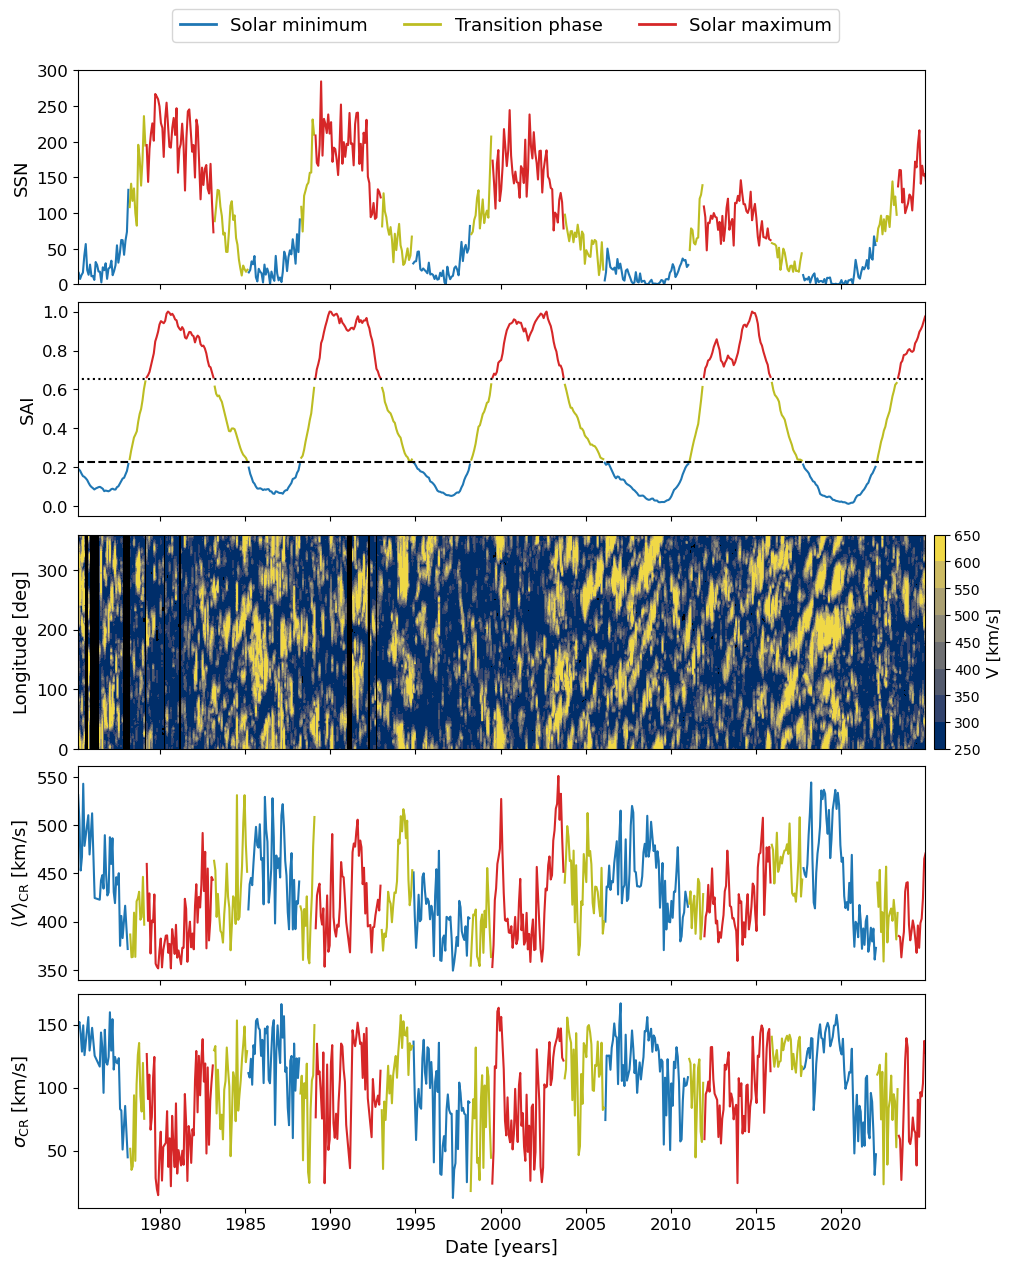

In [8]:
def solarwind_time_longitude_map_plot():
    """
    Produce a time-longitude plot of the MAS equatorial solar wind speed, to show how solar wind model boundary conditions change in time.
    """

    # load in the CME transit time data
    data_path = "/Users/dven/repos/CME_transit_variability/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])

    cr_nums_pad = np.arange(cr_nums.min(), cr_nums.max() + 1, 1)
    cr_time_pad = carrington_rotation_time(cr_nums_pad + 0.5)
    vsw_bc = []

    for cr_num in cr_nums_pad:
        cr_tag = "CR_{}".format(cr_num)

        if cr_tag in cr_keys and 'vr_21' in data[cr_tag]:
            # Get BC variability
            vsw_bc.append(data[cr_tag + '/vr_21'][:])
        else:
            vsw_bc.append(np.nan*np.ones(360))

    vsw = np.array(vsw_bc)
    lons = np.arange(0,360,1)

    fig, ax = plt.subplots(5,1, figsize=(10,12), facecolor='white', sharex=True, layout='constrained')
    
    ssn = load_ssn_sai()
    cme_avg, cme_fst = load_reduced_transit_data()

    terciles = ssn['sai'].quantile([0.333, 0.666]).values
    colors = ['tab:blue', 'tab:olive', 'tab:red']
    labels = ['Lower tercile', 'Middle tercile', 'Upper tercile']

    # Create legend handles outside the loop
    legend_handles = [
        plt.Line2D([0], [0], color='tab:blue', lw=2, label='Solar minimum'),
        plt.Line2D([0], [0], color='tab:olive', lw=2, label='Transition phase'),
        plt.Line2D([0], [0], color='tab:red', lw=2, label='Solar maximum')
    ]

    id_low = ssn['sai'] <= terciles[0]
    id_mid = (ssn['sai'] >= terciles[0]) & (ssn['sai'] <= terciles[1])
    id_high = ssn['sai'] >= terciles[1]

    for id_sub, col, label in zip([id_low, id_mid, id_high], colors, labels):

        ssn_c = ssn.copy()
        ssn_c[np.logical_not(id_sub)] = np.NaN

        ax[0].plot(ssn_c['datetime'], ssn_c['ssn'], '-', color=col, label=label)
        ax[1].plot(ssn_c['datetime'], ssn_c['sai'], '-', color=col)

    linestyles = ['--', ':']
    ax[1].hlines(terciles, ssn['datetime'].min(), ssn['datetime'].max(), colors=['k'], linestyles=linestyles )

    id_low = cme_avg['sai'] <= terciles[0]
    id_mid = (cme_avg['sai'] > terciles[0]) & (cme_avg['sai'] <= terciles[1])
    id_high = cme_avg['sai'] > terciles[1]

    for id_sub, col in zip([id_low, id_mid, id_high], colors):
        cme_dup = cme_avg.copy()
        cme_dup[np.logical_not(id_sub)] = np.NaN
        ax[3].plot(cme_dup['datetime'], cme_dup['vsw_avg'], '-', color=col)
        ax[4].plot(cme_dup['datetime'], cme_dup['vsw_var'], '-', color=col)

    ax[2].set_facecolor('k')
    levels = np.arange(250, 700, 50)
    cmap = copy.copy(mpl.cm.get_cmap('cividis'))
    cmap.set_bad(color='k', alpha=1)

    cnt = ax[2].contourf(cr_time_pad.datetime, lons, vsw.T, levels=levels, cmap=cmap, vmin=levels[0], vmax=levels[-1])

    cbar = fig.colorbar(cnt, ax=ax[2], pad=0.01)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_ylabel('V [km/s]', fontsize=12)

    for a in ax:
        a.set_xlim(cme_avg['datetime'].min(), cme_avg['datetime'].max())
        a.tick_params(axis='y', labelsize=12)
        a.tick_params(axis='x', labelsize=12)

    #for a in ax[:-1]:
        #a.set_xticklabels([])

    ax[0].set_ylim(0,300)

    ax[-1].set_xlabel('Date [years]', fontsize=13)
    ax[0].set_ylabel('SSN', fontsize=13)
    ax[1].set_ylabel('SAI', fontsize=13)
    ax[2].set_ylabel('Longitude [deg]', fontsize=13)
    ax[3].set_ylabel(r'$\langle V \rangle_{\mathrm{CR}}$ [km/s]', fontsize=13)
    ax[4].set_ylabel(r'$\sigma_{\mathrm{CR}}$ [km/s]', fontsize=13)

    # Create a single legend outside the plot
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=13, ncol=3)

    fig.subplots_adjust(left=0.085, bottom=0.06, right=0.99, top=0.99, hspace=0.04)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/Vsw_timeseries.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')

    data.close()
    return

solarwind_time_longitude_map_plot()

Figure 1. A time-longitude map of the equatorial solar wind speed from the MAS coronal model output at 21.5 solRad (backmapped from 30 solRad using HUXt). In this work these data are used as the boundary conditions to the HUXt solar wind simulations. Black vertical stripes mark Carrington rotations where the MAS solutions were unavailable.

Files already exist for CR1625
Files already exist for CR1625
day 11 transit time =  2.495633109472692
day 11 arrival speed 653.8124335993648
day 12 transit time =  3.1208235188387334
day 12 arrival speed 504.1283412319087


/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_19964/1798499991.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cnt.collections:
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_19964/1798499991.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cnt.collections:
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_19964/1798499991.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cnt.collections:
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_19964/1798499991.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cnt.collections:
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_19964/1798499991.py:42: M

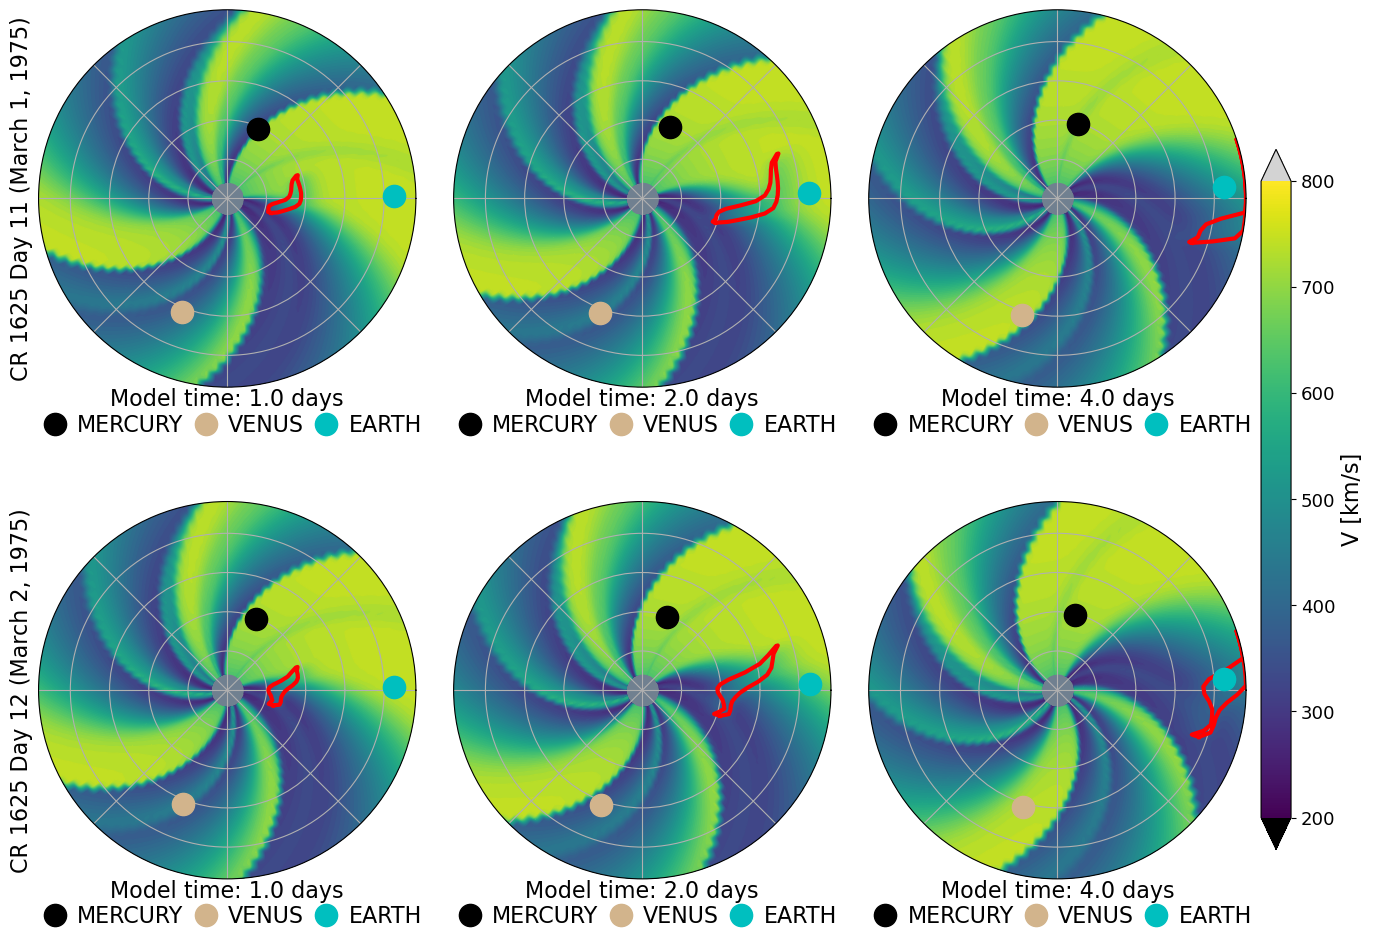

In [8]:
def plot_huxt_example():
    """
    Make example plot of Cone CME evolution.
    Returns:
    """
    # Run HUXt with climatological average CME and plot at 3 timesteps - initiation, middle, and arrival at Earth
    cme = H.ConeCME(t_launch=0 * u.day, longitude=0.0 * u.deg, width=37.4 * u.deg, v=495 * (u.km / u.s), thickness=0 * u.solRad, initial_height=21.5 * u.solRad)
    cme_fast = H.ConeCME(t_launch=0 * u.day, longitude=0.0 * u.deg, width=69.8 * u.deg, v=1070 * (u.km / u.s), thickness=0 * u.solRad, initial_height=21.5 * u.solRad)
    
    cr_num_min = 1625
    cr_num_max = 1625
    
    vr_mas_min = HI.get_MAS_long_profile(cr_num_min, lat=0.0 * u.deg)
    vr_mas_max = HI.get_MAS_long_profile(cr_num_max, lat=0.0 * u.deg)

    #  Map the inner boundary MAS values inwards from 30 rS to 21.5 rS
    vr_21_min = HI.map_v_boundary_inwards(vr_mas_min, 30*u.solRad, 21.5*u.solRad)
    vr_21_max = HI.map_v_boundary_inwards(vr_mas_max, 30*u.solRad, 21.5*u.solRad)
    
    #  Setup HUXt to do a 6 day simulation, with model output every 4 timesteps (roughly half and hour time step)
    model_min = H.HUXt(v_boundary=vr_21_min, cr_num=cr_num_min, cr_lon_init=(360*16/27)*u.deg, simtime=6*u.day, dt_scale=4, r_min=21.5*u.solRad, frame = 'sidereal')
    model_max = H.HUXt(v_boundary=vr_21_max, cr_num=cr_num_max, cr_lon_init=(360*15/27)*u.deg, simtime=6*u.day, dt_scale=4, r_min=21.5*u.solRad, frame = 'sidereal')
    
    model_min.solve([cme])
    model_max.solve([cme])

    # Compute the transit time
    stats = model_min.cmes[0].compute_arrival_at_body('EARTH')
    print("day 11 transit time = ",stats['t_transit'].value)
    arrival_time = stats['t_arrive']

    # Find the arrival speed within 1 day of arrival
    earth_series = HA.get_observer_timeseries(model_min, observer='Earth')
    mask = (Time(earth_series['time']) >= arrival_time) & (Time(earth_series['time']) <= arrival_time + 3 * u.day)
    print("day 11 arrival speed",earth_series.loc[mask, 'vsw'].max())

    # Compute the transit time
    stats = model_max.cmes[0].compute_arrival_at_body('EARTH')
    print("day 12 transit time = ",stats['t_transit'].value)
    arrival_time = stats['t_arrive']

    # Find the arrival speed within 1 day of arrival
    earth_series = HA.get_observer_timeseries(model_max, observer='Earth')
    mask = (Time(earth_series['time']) >= arrival_time) & (Time(earth_series['time']) <= arrival_time + 3 * u.day)
    print("day 12 arrival speed",earth_series.loc[mask, 'vsw'].max())

    fig, ax = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={"projection": "polar"})
    
    models = [model_min, model_max]
    labels = ["CR 1625 Day 11 (March 1, 1975)", "CR 1625 Day 12 (March 2, 1975)"]
    
    for row, (model, label) in enumerate(zip(models, labels)):
        cme = model.cmes[0]
        stats = cme.compute_arrival_at_body('Earth')
        hit_id = stats['hit_id']
        halfway_id = np.int64(np.fix(hit_id / 2.0))
    
        for col, time_out in enumerate([1 * u.day, 2 * u.day, 4 * u.day]):
            id_t = plot_huxt_multi(ax[row, col], time_out, model)
    
            time_label = "Model time: {:3.1f} days".format(model.time_out[id_t].to(u.day).value)
            ax[row, col].text(0.5, -0.05, time_label, ha='center', fontsize=16, transform=ax[row, col].transAxes)
        
        ax[row, 0].set_ylabel(label, fontsize=16)
    
    fig.subplots_adjust(left=0.075, bottom=0.12, right=0.88, top=0.99, wspace=0.1, hspace=0.3)
    
    mymap = mpl.cm.viridis
    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    norm = mpl.colors.Normalize(vmin=200, vmax=800)
    smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)
    
    cbaxes = fig.add_axes([0.89, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('V [km/s]')
    
    for row in range(2):
        for col in range(3):
            ax[row, col].legend(bbox_to_anchor=(0.5, -0.1), loc="center", ncol=3, frameon=False, handletextpad=0.0, columnspacing=0.0)
    
    dirs = H._setup_dirs_()
    fig_name = 'cone_cme_example'
    fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".pdf")
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')

    
    return

plot_huxt_example()

Figure 2: Example simulation of CME propagation through ambient solar wind for Carrington rotation numbers 1625. Statistically average CME was launched at Day 11 (213 degrees) and Day 12 (200 degrees) at 21.5 solRad. The figure shows position of CME (in red perimeter) 1, 2, and 4 days after launch.

Files already exist for CR1650
Files already exist for CR1688
Files already exist for CR1650
Files already exist for CR1688
No initiation time specified. Defaulting to start of CR2000, 20/2/2003
No initiation time specified. Defaulting to start of CR2000, 20/2/2003


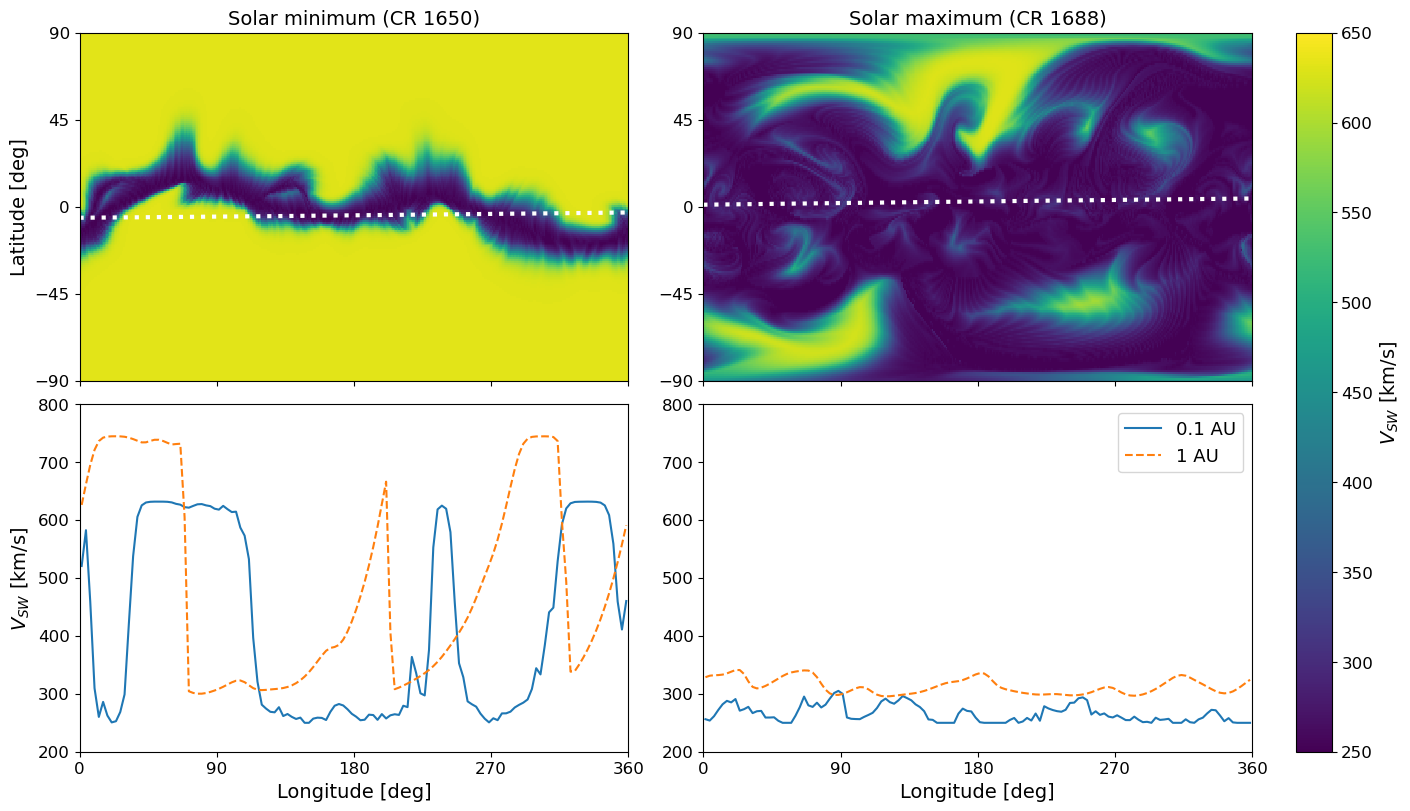

In [9]:
def MAS_map():
    """
    Generate side-by-side plot of MAS maps at two Carrington numbers with Earth's latitude indicated (dotted white line),
    and corresponding 1D vr profile below each plot. Includes shared vertical colorbar.
    """
    # Carrington rotations
    cr1, cr2 = 1650, 1688

    # Load MAS boundary conditions and vr maps
    HI.get_MAS_boundary_conditions(cr=cr1)
    HI.get_MAS_boundary_conditions(cr=cr2)
    
    vr_map1_orig, vr_longs1, vr_lats1, _, _, _ = HI.read_MAS_vr_br(cr1)
    vr_map2_orig, vr_longs2, vr_lats2, _, _, _ = HI.read_MAS_vr_br(cr2)

    vr_map1 = HI.map_vmap_inwards(v_map=vr_map1_orig, v_map_lat=vr_longs1, v_map_long=vr_lats1, r_orig=30*u.solRad, r_new=21.5*u.solRad)
    vr_map2 = HI.map_vmap_inwards(v_map=vr_map2_orig, v_map_lat=vr_longs2, v_map_long=vr_lats2, r_orig=30*u.solRad, r_new=21.5*u.solRad)

    # Convert latitude to co-latitude
    vr_lats1 = (np.pi / 2 - (vr_lats1.to(u.rad)).value) * u.rad
    vr_lats2 = (np.pi / 2 - (vr_lats2.to(u.rad)).value) * u.rad

    # Convert longitudes
    cr_lon1 = vr_longs1.to(u.deg)
    cr_lon2 = vr_longs2.to(u.deg)

    # Compute Earth's latitude as a function of Carrington longitude (as Quantity in degrees)
    earth_lat1 = [get_earth_lat(cr1, lon) * u.deg for lon in cr_lon1]
    earth_lat2 = [get_earth_lat(cr2, lon) * u.deg for lon in cr_lon2]

    # Function to extract vr values at Earth's latitude
   # def extract_vr_line(vr_map, vr_lats, target_lats):
    #    vr_lats_deg = vr_lats.to_value(u.deg)
     #   line = []
      #  for i, lat in enumerate(target_lats):
       #     lat_deg = lat.to_value(u.deg)
        #    idx = np.argmin(np.abs(vr_lats_deg - lat_deg))
         #   line.append(vr_map[i, idx].to_value(u.km / u.s))
       # return line

    #vr1_line = extract_vr_line(vr_map1, vr_lats1, earth_lat1)
    #vr2_line = extract_vr_line(vr_map2, vr_lats2, earth_lat2)

    # Running HUXt to get 1 AU speeds
    vr_long_min = HI.get_MAS_long_profile(cr1, lat=0.0 * u.deg)
    vr_long_max = HI.get_MAS_long_profile(cr2, lat=0.0 * u.deg)

    vr_21_min = HI.map_v_boundary_inwards(vr_long_min, 30*u.solRad, 21.5*u.solRad)
    vr_21_max = HI.map_v_boundary_inwards(vr_long_max, 30*u.solRad, 21.5*u.solRad)
    
    model_min = H.HUXt(v_boundary=vr_21_min, simtime=0.1*u.day, dt_scale=4, r_min=21.5*u.solRad, r_max=215*u.solRad)
    model_max = H.HUXt(v_boundary=vr_21_max, simtime=0.1*u.day, dt_scale=4, r_min=21.5*u.solRad, r_max=215*u.solRad)

    model_min.solve([])
    model_max.solve([])

    vr1_21 = model_min.v_grid[0,0,:]
    vr2_21 = model_max.v_grid[0,0,:]
    
    vr1_215 = model_min.v_grid[0,-1,:]
    vr2_215 = model_max.v_grid[0,-1,:]

    lon_min = model_min.lon.to(u.deg)
    lon_max = model_max.lon.to(u.deg)

    # Create a 2-row, 2-column subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col', layout='constrained')

    # Titles
    axes[0, 0].set_title(f"Solar minimum (CR {cr1})", fontsize=14)
    axes[0, 1].set_title(f"Solar maximum (CR {cr2})", fontsize=14)

    # 2D vr maps (top row)
    pc1 = plotspeedmap(axes[0, 0], vr_map1, vr_longs1, vr_lats1)
    pc2 = plotspeedmap(axes[0, 1], vr_map2, vr_longs2, vr_lats2)
    axes[0, 0].set_ylabel('Latitude [deg]', fontsize=14)

    # Earth orbit lines
    axes[0, 0].plot(cr_lon1, [lat.to_value(u.deg) for lat in earth_lat1], 'w:', lw=3)
    axes[0, 1].plot(cr_lon2, [lat.to_value(u.deg) for lat in earth_lat2], 'w:', lw=3)

    # 1D line plots (bottom row)
    axes[1, 0].plot(lon_min, vr1_21, color='tab:blue', label='0.1 AU')
    axes[1, 1].plot(lon_max, vr2_21, color='tab:blue', label='0.1 AU')

    # 1 AU speeds
    axes[1, 0].plot(lon_min, vr1_215, linestyle='--', color='tab:orange', label='1 AU')
    axes[1, 1].plot(lon_max, vr2_215, linestyle='--', color='tab:orange', label='1 AU')
    axes[1, 1].legend(fontsize=13)

    axes[1, 0].set_ylabel(r'$V_{SW}$ [km/s]', fontsize=14)
    axes[1, 0].set_ylim([200,800])
    axes[1, 1].set_ylim([200,800])
    axes[1, 0].set_xlabel('Longitude [deg]', fontsize=14)
    axes[1, 1].set_xlabel('Longitude [deg]', fontsize=14)

    axes[0,0].tick_params(axis='y', labelsize=12)
    axes[0,1].tick_params(axis='y', labelsize=12)
    axes[1,0].tick_params(axis='y', labelsize=12)
    axes[1,1].tick_params(axis='y', labelsize=12)
    axes[1,0].tick_params(axis='x', labelsize=12)
    axes[1,1].tick_params(axis='x', labelsize=12)

    # Add vertical colorbar to the right of the top row
    cb = fig.colorbar(pc1, ax=axes[:, 1], location='right')
    cb.ax.tick_params(labelsize=12)
    cb.set_label(r'$V_{SW}$ [km/s]', fontsize=14)

    # Save the final figure
    fig.savefig("/Users/dven/repos/CME_transit_climatology_new/figures/MAS_map.pdf", dpi=300, bbox_inches='tight')

MAS_map()


Figure 3: MAS solar wind map at 21.5 solRad with Earth's position given by dotted white line

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_10939/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


Average CME $\tau$ - Solar minimum Median: 91.35
Average CME $\tau$ - Solar maximum Median: 95.80
Average CME $V_{1AU}$ - Solar minimum Median: 403.15
Average CME $V_{1AU}$ - Solar maximum Median: 377.60
Fast CME $\tau$ - Solar minimum Median: 72.38
Fast CME $\tau$ - Solar maximum Median: 75.99
Fast CME $V_{1AU}$ - Solar minimum Median: 455.05
Fast CME $V_{1AU}$ - Solar maximum Median: 429.61


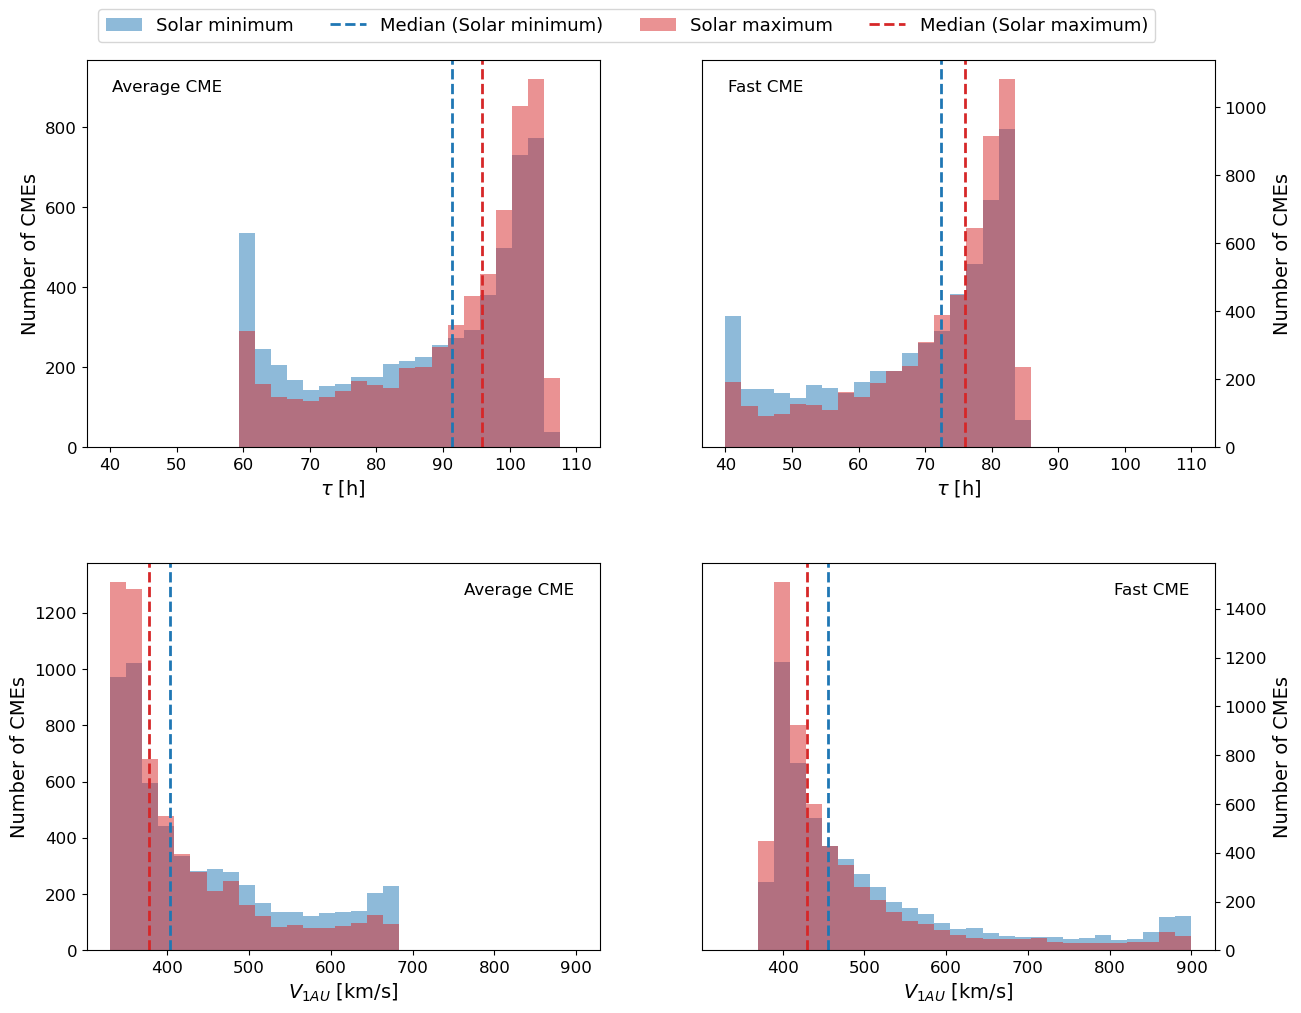

In [9]:
def histogram_transit_vcme_sai():
    """
    Produce histograms of 'transits' and 'v' variables for the lower and upper terciles of the SAI distribution
    for both Average CME and Fast CME scenarios. Uses 50 bins for all histograms.
    """
    cme_avg, cme_fst = load_transit_data()
    
    datasets = [(cme_avg, 'Average CME'), (cme_fst, 'Fast CME')]
    colors = {'lower': 'tab:blue', 'upper': 'tab:red'}
    labels = {'lower': 'Solar minimum', 'upper': 'Solar maximum'}
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10), facecolor='white')
    handles, labels_legend = [], []
    
    for i, (cme, cme_label) in enumerate(datasets):
        terciles = cme['sai'].quantile([0.333, 0.666]).values
        id_low = cme['sai'] <= terciles[0]
        id_high = cme['sai'] > terciles[1]
        
        data_dict = {
            'lower': {'transits': cme.loc[id_low, 'transits'], 'v': cme.loc[id_low, 'v']},
            'upper': {'transits': cme.loc[id_high, 'transits'], 'v': cme.loc[id_high, 'v']}
        }
        
        for j, (var, title) in enumerate(zip(['transits', 'v'], [r'$\tau$', r'$V_{1AU}$'])):

            bins = np.linspace(40 if var == 'transits' else 330, 110 if var == 'transits' else 900, 30)
            
            for key in ['lower', 'upper']:
                data = data_dict[key][var]
                hist = ax[j, i].hist(data, bins=bins, density=False, alpha=0.5, color=colors[key])
                median_val = np.median(data)
                ax[j, i].axvline(median_val, color=colors[key], linestyle='dashed', linewidth=2)
                
                print(f"{cme_label} {title} - {labels[key]} Median: {median_val:.2f}")
                
                if i == 0 and j == 0:  # Collect legend handles once
                    handles.append(hist[2][0])
                    labels_legend.append(f'{labels[key]}')
                    handles.append(plt.Line2D([0], [0], color=colors[key], linestyle='dashed', linewidth=2))
                    labels_legend.append(f'Median ({labels[key]})')
            
            ax[j, i].set_xlabel(f'{title} [{"h" if var == "transits" else "km/s"}]',fontsize=14)
            ax[j, i].set_ylabel('Number of CMEs',fontsize=14)
            ax[j, i].tick_params(axis='y', labelsize=12)
            ax[j, i].tick_params(axis='x', labelsize=12)
            
            ax[j, i].text(
                0.05 if j == 0 else 0.95,  # left-aligned for first row, right-aligned for second
                0.95,
                f'{cme_label}',
                transform=ax[j, i].transAxes,
                fontsize=12,
                ha='left' if j == 0 else 'right',
                va='top'
            )

    # Move y-axis of second column to the right
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position('right')
    ax[1, 1].yaxis.tick_right()
    ax[1, 1].yaxis.set_label_position('right')
    
    fig.legend(handles, labels_legend, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2, hspace=0.3)
    
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/histogram_both.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')
    
    return

histogram_transit_vcme_sai()

Figure 4: Resulting transit time and arrival speed distribution

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year

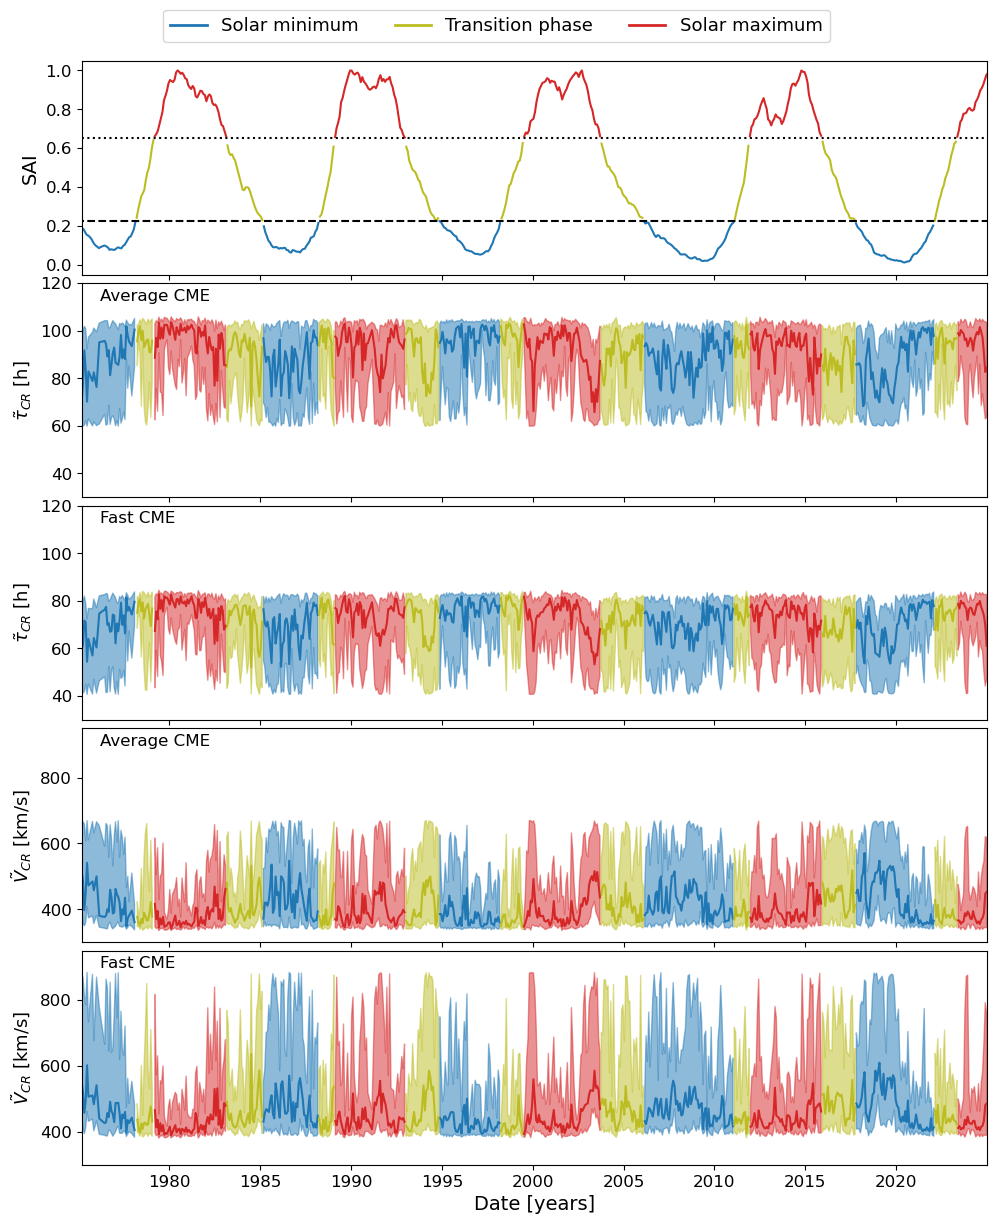

In [56]:
def solar_activity_and_tv_series():
    """
    Time series plot showing SAI, transit time, and arrival speed statistics over each Carrington rotation.
    Produces a 5-panel vertically stacked plot.
    """

    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(5, 1, figsize=(10, 12), facecolor='white')

    ssn = load_ssn_sai()
    cme_avg_tt, cme_fst_tt = load_reduced_transit_data()
    cme_avg_v, cme_fst_v = load_reduced_v_data()

    terciles = ssn['sai'].quantile([0.333, 0.666]).values
    colors = ['tab:blue', 'tab:olive', 'tab:red']
    labels = ['Lower tercile', 'Middle tercile', 'Upper tercile']

    legend_handles = [
        plt.Line2D([0], [0], color='tab:blue', lw=2, label='Solar minimum'),
        plt.Line2D([0], [0], color='tab:olive', lw=2, label='Transition phase'),
        plt.Line2D([0], [0], color='tab:red', lw=2, label='Solar maximum')
    ]

    # --- Panel 0: SAI ---
    for id_sub, col, label in zip(
        [ssn['sai'] <= terciles[0],
         (ssn['sai'] >= terciles[0]) & (ssn['sai'] <= terciles[1]),
         ssn['sai'] > terciles[1]],
        colors,
        labels
    ):
        ssn_c = ssn.copy()
        ssn_c[np.logical_not(id_sub)] = np.NaN
        ax[0].plot(ssn_c['datetime'], ssn_c['sai'], '-', color=col)

    ax[0].hlines(terciles, ssn['datetime'].min(), ssn['datetime'].max(), colors='k', linestyles=['--', ':'])

    # Helper: plot CME panels
    def plot_cme_panel(a, cme, label, ylims, ylabel):
        for id_sub, col in zip(
            [cme['sai'] <= terciles[0],
             (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1]),
             cme['sai'] > terciles[1]],
            colors
        ):
            cme_dup = cme.copy()
            cme_dup[np.logical_not(id_sub)] = np.NaN
            a.plot(cme_dup['datetime'], cme_dup['avg'], '-', color=col, zorder=2)
            a.fill_between(cme_dup['datetime'], cme_dup['q1'], cme_dup['q9'], color=col, alpha=0.5, zorder=1)

        a.text(0.02, 0.92, label, transform=a.transAxes, fontsize=12)
        a.set_ylim(*ylims)
        a.set_ylabel(ylabel, fontsize=13)

    # Panels 1–2: Transit Time
    plot_cme_panel(ax[1], cme_avg_tt, 'Average CME', ylims=(30, 120), ylabel=r'$\tilde{\tau}_{CR}$ [h]')
    plot_cme_panel(ax[2], cme_fst_tt, 'Fast CME', ylims=(30, 120), ylabel=r'$\tilde{\tau}_{CR}$ [h]')

    # Panels 3–4: Arrival Speed
    plot_cme_panel(ax[3], cme_avg_v, 'Average CME ', ylims=(300, 950), ylabel=r'$\tilde{V}_{CR}$ [km/s]')
    plot_cme_panel(ax[4], cme_fst_v, 'Fast CME', ylims=(300, 950), ylabel=r'$\tilde{V}_{CR}$ [km/s]')

    # Axis formatting
    for a in ax:
        a.set_xlim(cme_avg_tt['datetime'].min(), cme_avg_tt['datetime'].max())
        a.tick_params(axis='y', labelsize=12)
        a.tick_params(axis='x', labelsize=12)

    for a in ax[:-1]:
        a.set_xticklabels([])

    ax[-1].set_xlabel('Date [years]', fontsize=14)
    ax[0].set_ylabel('SAI', fontsize=14)

    # Shared legend
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.03), fontsize=13, ncol=3)

    fig.subplots_adjust(left=0.085, bottom=0.06, right=0.99, top=0.98, hspace=0.04)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/transit_speed_timeseries.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')

    return

solar_activity_and_tv_series()

Figure 5: Transit time medians and inter-quartile range colored in terciles of Solar Activity Index (SAI): blue for lower tercile or solar minimum, olive for middle tercile, and red for upper tercile or solar maximum. Row 1: Solar Sunspot Number. Row 2: Solar Activity Index (SSN normalised to the max smoothed value in 1-solar cycle window centred on current time). Row 3: Variability in inner boundary solar wind speed (standard deviation of 1 carrington rotation0. Row 4: Transit time results for average CME. Row 5: Transit time results for fast CME.

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


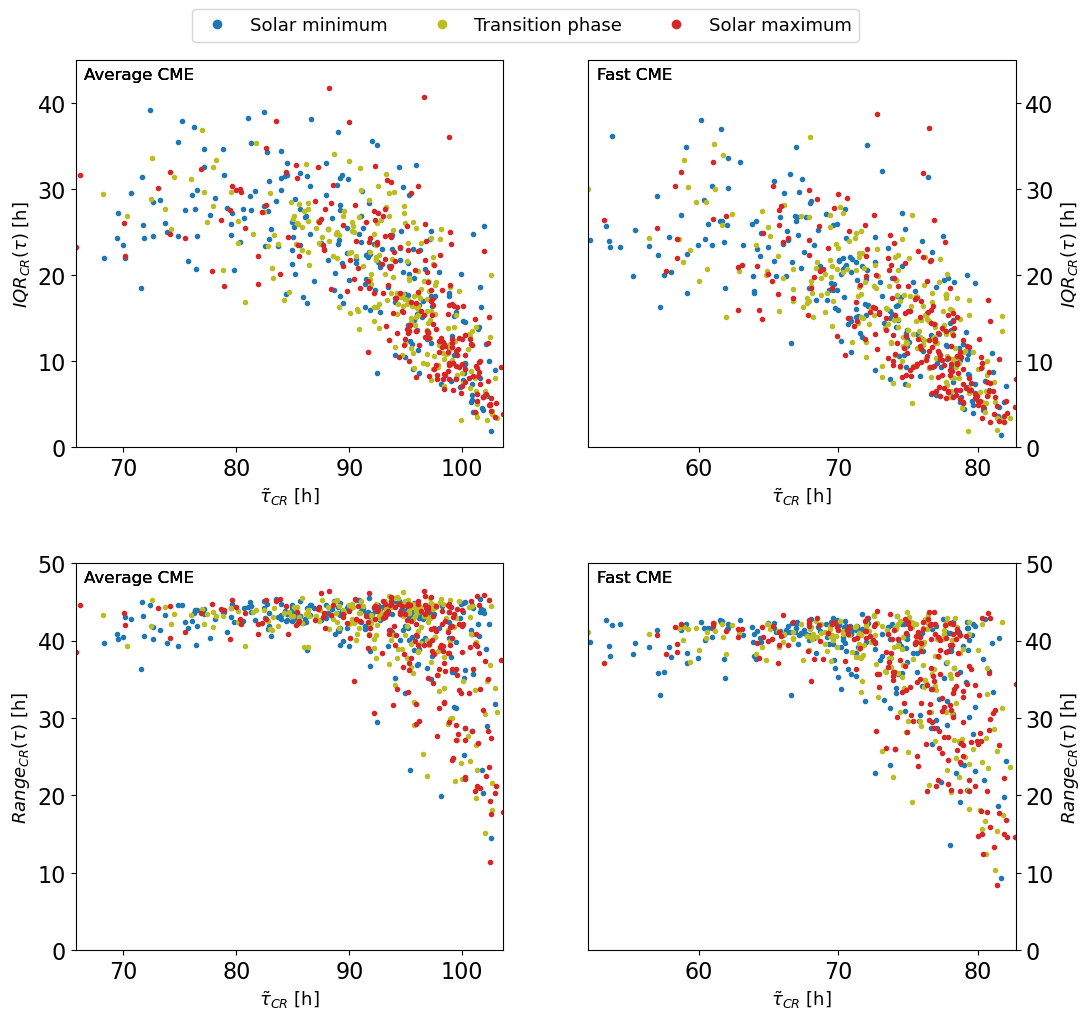

In [51]:
def transit_median_iqr_scatter():
    """
    Scatter plots of the CR median transit time vs transit time IQR for the average and fast CME scenarios
    Returns:
    """
    cme_avg, cme_fst = load_reduced_transit_data()

    # Define terciles for SAI
    terciles = cme_avg['sai'].quantile([0.333, 0.666]).values
    colors = ['tab:blue', 'tab:olive', 'tab:red']
    labels = ['Solar minimum', 'Transition phase', 'Solar maximum']

    # Create figure with 2 rows and 2 columns
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    # Initialize lists for legend handles and labels
    legend_handles = []
    legend_labels = []

    for i, (cme, label) in enumerate(zip([cme_avg, cme_fst], ['Average CME', 'Fast CME'])):
        # Create mask for the terciles
        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        for id_sub, col, label_t in zip([id_low, id_mid, id_high], colors, labels):
            # Mask the data for the corresponding tercile
            cme_copy = cme.copy()
            cme_copy[np.logical_not(id_sub)] = np.NaN

            # Plot Transit Time Median vs IQR
            scatter_iqr = ax[0, i].plot(cme_copy['avg'], cme_copy['iqr'], '.', color=col, label=label_t)
            ax[0, i].set_xlabel(r'$\tilde{\tau}_{CR}$ [h]', fontsize=13)
            ax[0, i].set_ylabel(r'$IQR_{CR}(\tau)$ [h]', fontsize=13)
            ax[0, i].set_ylim(0,45)
            ax[0, i].text(0.02, 0.95, label, transform=ax[0, i].transAxes, fontsize=12)

            # Plot Transit Time Median vs Range (for second row)
            scatter_range = ax[1, i].plot(cme_copy['avg'], cme_copy['range'], '.', color=col, label=label_t)
            ax[1, i].set_xlabel(r'$\tilde{\tau}_{CR}$ [h]', fontsize=13)
            ax[1, i].set_ylabel(r'$Range_{CR}(\tau)$ [h]', fontsize=13)
            ax[1, i].set_ylim(0, 50)
            ax[1, i].text(0.02, 0.95, label, transform=ax[1, i].transAxes, fontsize=12)

        # Add labels and limits
        ax[0, i].set_xlim(cme['avg'].min(), cme['avg'].max())
        ax[1, i].set_xlim(cme['avg'].min(), cme['avg'].max())

    # Create a single legend for the entire plot
    for col, label in zip(colors, labels):
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=8)
        legend_handles.append(handle)
        legend_labels.append(label)

    fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=13, ncol=3)

    # Move y-axis of second column to the right
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position('right')
    ax[1, 1].yaxis.tick_right()
    ax[1, 1].yaxis.set_label_position('right')

    # Adjust layout
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2, hspace=0.3)

    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/transit_scatter.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')

    return

transit_median_iqr_scatter()


Figure 6: Scatterplot of transit time variability versus transit time median colored to specify terciles of SAI. Row 1: Average and fast cme transit time iqrs. Row 2: Average and fast cme transit time ranges.  

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


Average CME $\tilde{\tau}_{CR}$ - Solar minimum Median: 90.86
Average CME $\tilde{\tau}_{CR}$ - Solar maximum Median: 96.07
Average CME $IQR_{CR}(\tau)$ - Solar minimum Median: 22.97
Average CME $IQR_{CR}(\tau)$ - Solar maximum Median: 16.72
Fast CME $\tilde{\tau}_{CR}$ - Solar minimum Median: 71.57
Fast CME $\tilde{\tau}_{CR}$ - Solar maximum Median: 76.06
Fast CME $IQR_{CR}(\tau)$ - Solar minimum Median: 18.99
Fast CME $IQR_{CR}(\tau)$ - Solar maximum Median: 12.92


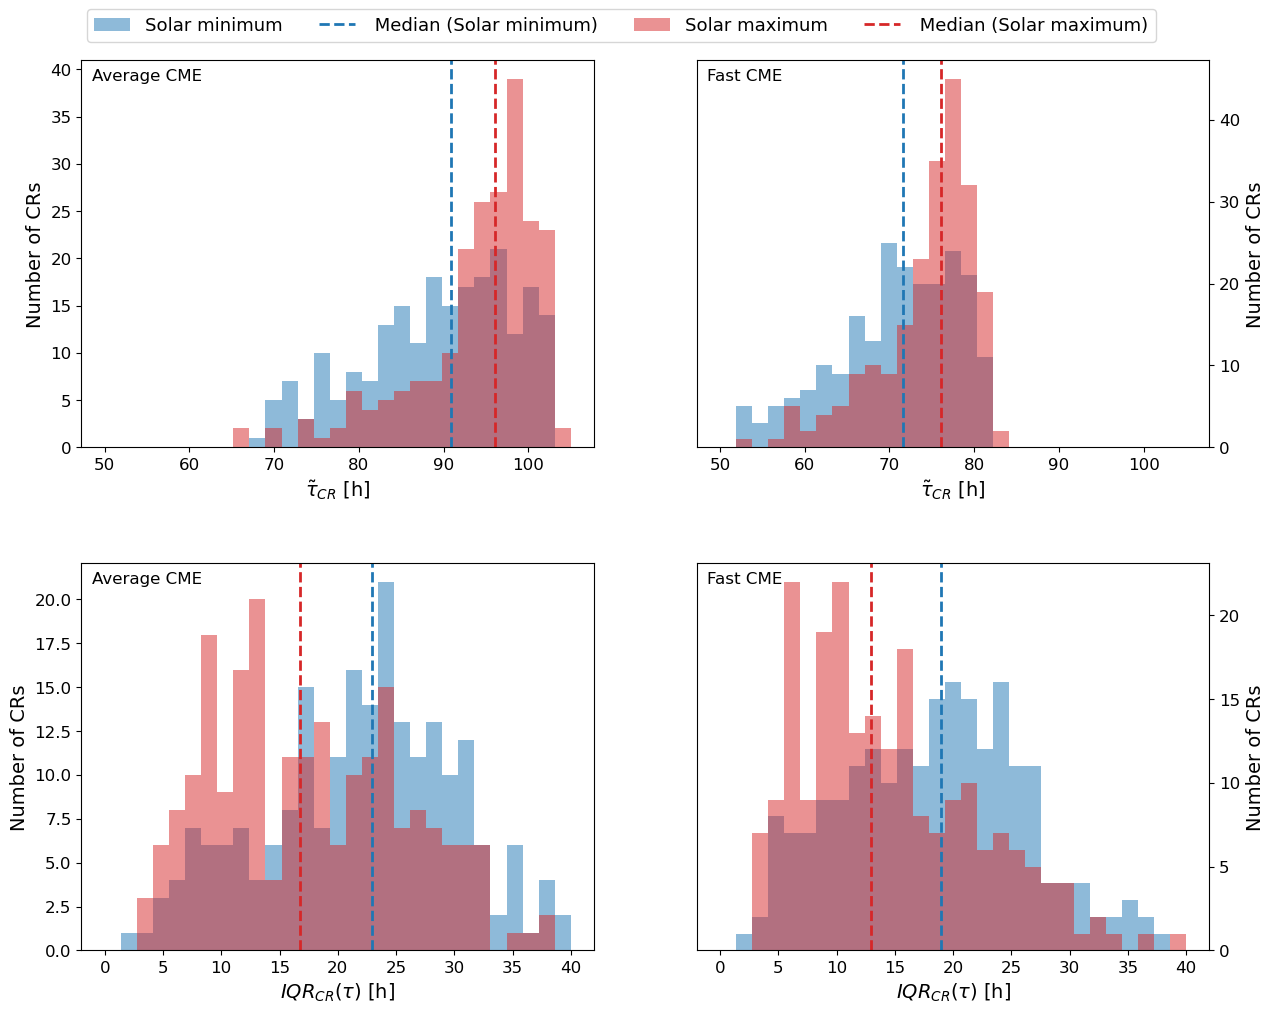

In [57]:
def histogram_sai_transit_iqr_range():
    """
    Produce histograms of the 'iqr' and 'range' variables for the lower and upper terciles of the SAI distribution
    for both Average CME and Fast CME scenarios. The titles are moved inside the plot and a single combined legend is used for the entire figure.
    Returns:
    """
    cme_avg, cme_fst = load_reduced_transit_data()
    
    datasets = [(cme_avg, 'Average CME'), (cme_fst, 'Fast CME')]
    colors = {'lower': 'tab:blue', 'upper': 'tab:red'}
    labels = {'lower': 'Solar minimum', 'upper': 'Solar maximum'}
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10), facecolor='white')
    handles, labels_legend = [], []
    
    for i, (cme, cme_label) in enumerate(datasets):
        terciles = cme['sai'].quantile([0.333, 0.666]).values
        id_low = cme['sai'] <= terciles[0]
        id_high = cme['sai'] > terciles[1]
        
        data_dict = {
            'lower': {'avg': cme.loc[id_low, 'avg'], 'iqr': cme.loc[id_low, 'iqr']},
            'upper': {'avg': cme.loc[id_high, 'avg'], 'iqr': cme.loc[id_high, 'iqr']}
        }
        
        for j, (var, title) in enumerate(zip(['avg', 'iqr'], [r'$\tilde{\tau}_{CR}$', r'$IQR_{CR}(\tau)$'])):
            bins = np.linspace(0 if var == 'iqr' else 50, 40 if var == 'iqr' else 105, 30)
            
            for key in ['lower', 'upper']:
                hist = ax[j, i].hist(data_dict[key][var], bins=bins, density=False, alpha=0.5, color=colors[key])
                median_value = np.median(data_dict[key][var])
                ax[j, i].axvline(median_value, color=colors[key], linestyle='dashed', linewidth=2)
                
                print(f"{cme_label} {title} - {labels[key]} Median: {median_value:.2f}")
                
                if i == 0 and j == 0:  # Collect legend handles once
                    handles.append(hist[2][0])
                    labels_legend.append(f'{labels[key]}')
                    handles.append(plt.Line2D([0], [0], color=colors[key], linestyle='dashed', linewidth=2))
                    labels_legend.append(f' Median ({labels[key]})')
            
            ax[j, i].set_xlabel(f'{title} [h]',fontsize=14)
            ax[j, i].set_ylabel('Number of CRs',fontsize=14)
            ax[j, i].tick_params(axis='y', labelsize=12)
            ax[j, i].tick_params(axis='x', labelsize=12)
            #ax[j, i].set_ylim(0, 0.1)
            ax[j, i].text(0.02, 0.98, f'{cme_label}', transform=ax[j, i].transAxes, fontsize=12, ha='left', va='top')
    
    # Move y-axis of second column to the right
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position('right')
    ax[1, 1].yaxis.tick_right()
    ax[1, 1].yaxis.set_label_position('right')
    
    fig.legend(handles, labels_legend, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2, hspace=0.3)
    
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/transit_histogram.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')
    
    return

histogram_sai_transit_iqr_range()


Figure 7: Distribution of transit time variability in the form of histograms and median lines. Row 1: Transit time iqr for average and fast cmes: blue denotes lower tercile and red denotes uppert tercile of SAI. Row 2: Same for range. 

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


Average CME:Median: (D=0.309, p=1.549e-09)
Average CME:IQR: (D=0.258, p=9.292e-07)
Fast CME:Median: (D=0.290, p=1.825e-08)
Fast CME:IQR: (D=0.276, p=1.044e-07)


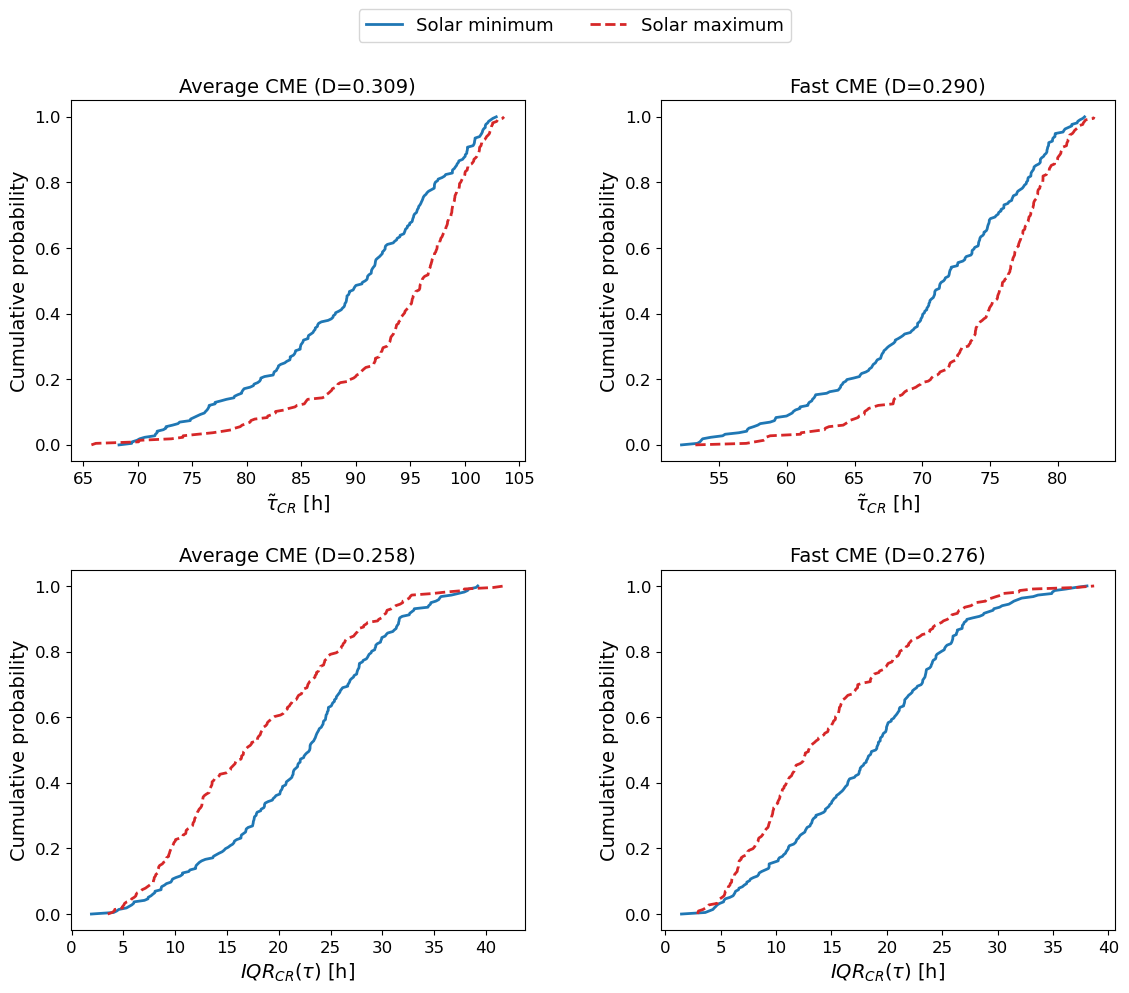

In [58]:
def ks_test_sai_transit_with_cdf():
    """
    Perform the KS test and visualize empirical CDFs for transit time IQR and Range
    between the lower and upper terciles of SAI for both Average and Fast CME scenarios.
    """

    cme_avg, cme_fst = load_reduced_transit_data()

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)

    for i, (cme, label) in enumerate(zip([cme_avg, cme_fst], ["Average CME", "Fast CME"])):
        # Calculate terciles
        terciles = cme['sai'].quantile([0.333, 0.666]).values

        # Identify lower and upper terciles
        id_low = cme['sai'] <= terciles[0]
        id_high = cme['sai'] > terciles[1]

        # Data for lower and upper terciles
        low_avg = np.sort(cme.loc[id_low, 'avg'])
        high_avg = np.sort(cme.loc[id_high, 'avg'])
        low_iqr = np.sort(cme.loc[id_low, 'iqr'])
        high_iqr = np.sort(cme.loc[id_high, 'iqr'])

        # Compute empirical CDFs
        cdf_low_avg = np.linspace(0, 1, len(low_avg))
        cdf_high_avg = np.linspace(0, 1, len(high_avg))
        cdf_low_iqr = np.linspace(0, 1, len(low_iqr))
        cdf_high_iqr = np.linspace(0, 1, len(high_iqr))

        # Perform KS test
        ks_stat_avg, p_value_avg = st.ks_2samp(low_avg, high_avg)
        ks_stat_iqr, p_value_iqr = st.ks_2samp(low_iqr, high_iqr)

        print((f"{label}:Median: (D={ks_stat_avg:.3f}, p={p_value_avg:.3e})"))
        print((f"{label}:IQR: (D={ks_stat_iqr:.3f}, p={p_value_iqr:.3e})"))

        # Plot CDF for Median
        axes[0, i].plot(low_avg, cdf_low_avg, label="Solar minimum", color="tab:blue", linewidth=2)
        axes[0, i].plot(high_avg, cdf_high_avg, label="Solar maximum", color="tab:red", linestyle="dashed", linewidth=2)
        axes[0, i].set_title(f"{label} (D={ks_stat_avg:.3f})", fontsize=14, loc="center")
        axes[0, i].set_xlabel(r'$\tilde{\tau}_{CR}$ [h]', fontsize=14)
        axes[0, i].set_ylabel("Cumulative probability", fontsize=14)
        axes[0, i].tick_params(axis='y', labelsize=12)
        axes[0, i].tick_params(axis='x', labelsize=12)
        
        # Plot CDF for IQR
        axes[1, i].plot(low_iqr, cdf_low_iqr, label="Solar minimum", color="tab:blue", linewidth=2)
        axes[1, i].plot(high_iqr, cdf_high_iqr, label="Solar maximum", color="tab:red", linestyle="dashed", linewidth=2)
        axes[1, i].set_title(f"{label} (D={ks_stat_iqr:.3f})", fontsize=14, loc="center")
        axes[1, i].set_xlabel(r'$IQR_{CR}(\tau)$ [h]', fontsize=14)
        axes[1, i].set_ylabel("Cumulative probability", fontsize=14)
        axes[1, i].tick_params(axis='y', labelsize=12)
        axes[1, i].tick_params(axis='x', labelsize=12)

    # Single legend for all subplots
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), fontsize=13, ncol=2)

    # Adjust layout for better spacing
    fig.subplots_adjust(left=0.08, bottom=0.12, right=0.95, top=0.95, wspace=0.3, hspace=0.3)

    # Save the figure
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/transit_ks_cdf.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches="tight")

    plt.show()

# Run the function
ks_test_sai_transit_with_cdf()


Figure 8: Cumulative distribution functions for transit time iqr (row 1) and range (row 2). Kolmogorov smirnov test was performed to test independence of lower/upper tercile SAI distributions for which the D and p-values are given. 

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/1891599543.py:30: MatplotlibDeprecationWarning: The 'labels' paramet

Average CME
Total samples: 650
Samples in low tercile: 217
Samples in mid tercile: 216
Samples in high tercile: 217
Median for lower tercile 22.969319315627217
Median for middle tercile 19.390679181553423
Median for upper tercile 16.72416210360825
Fast CME
Total samples: 650
Samples in low tercile: 217
Samples in mid tercile: 216
Samples in high tercile: 217
Median for lower tercile 18.987527299672365
Median for middle tercile 15.857694360427558
Median for upper tercile 12.922015964984894


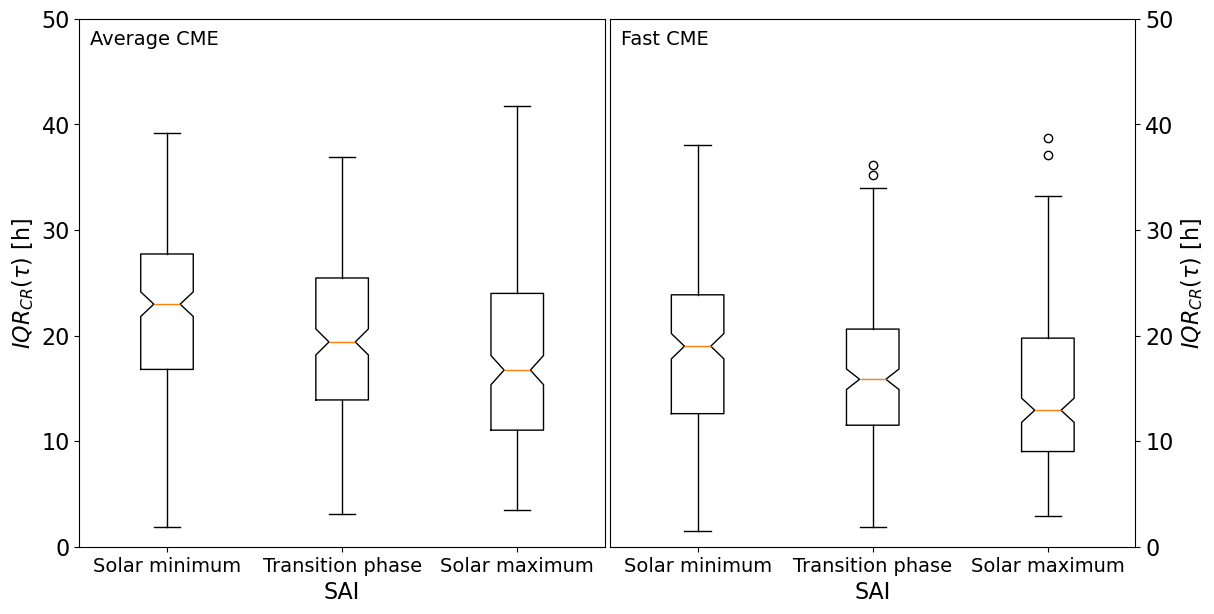

In [32]:
def boxplot_sai_transit_iqr():
    """
    Produce a boxplot of the distributions of the transit time IQR in each Carrington rotation partitioned by the terciles of the SAI distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
        labels = ['Solar minimum', 'Transition phase', 'Solar maximum']
        print('Median for lower tercile',np.median(boxplot_data[0]))
        print('Median for middle tercile',np.median(boxplot_data[1]))
        print('Median for upper tercile',np.median(boxplot_data[2]))
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.set_xticklabels(labels, fontsize=14)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('SAI')
        a.set_ylabel(r'$IQR_{CR}(\tau)$ [h]')
        a.set_ylim(0,50)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/transit_boxplot.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')
    
    return

boxplot_sai_transit_iqr()

Figure 9: Boxplots showing difference between the three terciles of SAI transit times for both average and fast cme.

In [26]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney():
    """
    Perform Mann-Whitney U test between lower and upper terciles for:
    - Fast CME IQR
    - Fast CME Range
    - Average CME IQR
    - Average CME Range
    """
    cme_avg, cme_fst = load_reduced_transit_data()

    comparisons = [
        ('Fast CME IQR', cme_fst['iqr']),
        ('Fast CME Range', cme_fst['range']),
        ('Average CME IQR', cme_avg['iqr']),
        ('Average CME Range', cme_avg['range'])
    ]
    
    for label, data in comparisons:
        terciles = data.quantile([0.333, 0.666]).values
        lower_tercile = data[data <= terciles[0]]
        upper_tercile = data[data > terciles[1]]

        stat, p_value = mannwhitneyu(lower_tercile, upper_tercile, alternative='two-sided')
        print(f"{label}: Mann-Whitney U test statistic = {stat:.3f}, p-value = {p_value:.3g}")

perform_mann_whitney()


/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Fast CME IQR: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72
Fast CME Range: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72
Average CME IQR: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72
Average CME Range: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72


/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_39780/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


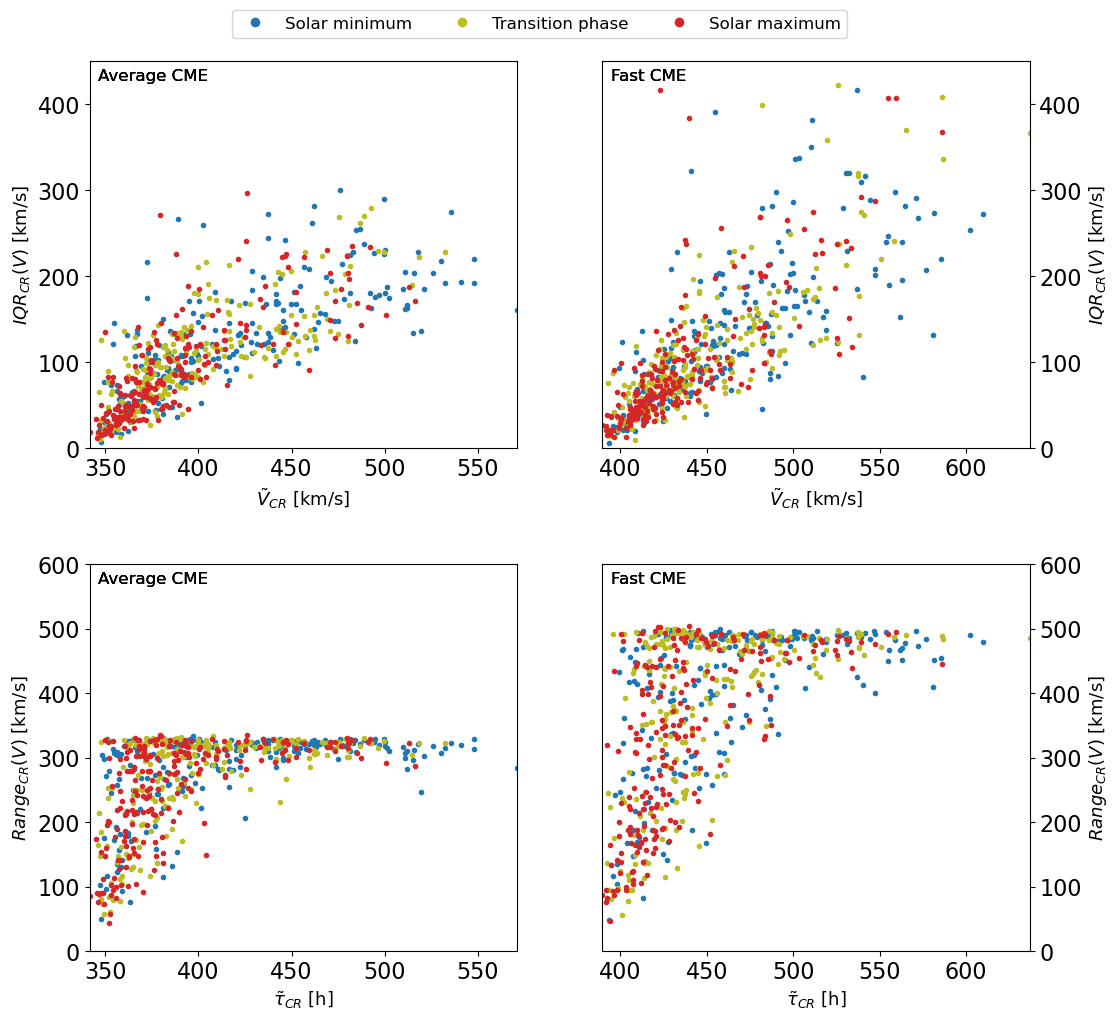

In [34]:
def arrival_median_iqr_scatter():
    """
    Scatter plots of the CR median arrival speed vs arrival speed IQR for the average and fast CME scenarios
    Returns:
    """
    cme_avg, cme_fst = load_reduced_v_data()

    # Define terciles for SAI
    terciles = cme_avg['sai'].quantile([0.333, 0.666]).values
    colors = ['tab:blue', 'tab:olive', 'tab:red']
    labels = ['Solar minimum', 'Transition phase', 'Solar maximum']

    # Create figure with 2 rows and 2 columns
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    # Initialize lists for legend handles and labels
    legend_handles = []
    legend_labels = []

    for i, (cme, label) in enumerate(zip([cme_avg, cme_fst], ['Average CME', 'Fast CME'])):
        # Create mask for the terciles
        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        for id_sub, col, label_t in zip([id_low, id_mid, id_high], colors, labels):
            # Mask the data for the corresponding tercile
            cme_copy = cme.copy()
            cme_copy[np.logical_not(id_sub)] = np.NaN

            # Plot Transit Time Median vs IQR
            scatter_iqr = ax[0, i].plot(cme_copy['avg'], cme_copy['iqr'], '.', color=col, label=label_t)
            ax[0, i].set_xlabel(r'$\tilde{V}_{CR}$ [km/s]', fontsize=13)
            ax[0, i].set_ylabel(r'$IQR_{CR}(V)$ [km/s]', fontsize=13)
            ax[0, i].set_ylim(0,450)
            ax[0, i].text(0.02, 0.95, label, transform=ax[0, i].transAxes, fontsize=12)

            # Plot Transit Time Median vs Range (for second row)
            scatter_range = ax[1, i].plot(cme_copy['avg'], cme_copy['range'], '.', color=col, label=label_t)
            ax[1, i].set_xlabel(r'$\tilde{\tau}_{CR}$ [h]', fontsize=13)
            ax[1, i].set_ylabel(r'$Range_{CR}(V)$ [km/s]', fontsize=13)
            ax[1, i].set_ylim(0, 600)
            ax[1, i].text(0.02, 0.95, label, transform=ax[1, i].transAxes, fontsize=12)

        # Add labels and limits
        ax[0, i].set_xlim(cme['avg'].min(), cme['avg'].max())
        ax[1, i].set_xlim(cme['avg'].min(), cme['avg'].max())

    # Create a single legend for the entire plot
    for col, label in zip(colors, labels):
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=8)
        legend_handles.append(handle)
        legend_labels.append(label)

    fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=12, ncol=3)

    # Move y-axis of second column to the right
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position('right')
    ax[1, 1].yaxis.tick_right()
    ax[1, 1].yaxis.set_label_position('right')

    # Adjust layout
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2, hspace=0.3)

    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/speed_scatter.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')

    return

arrival_median_iqr_scatter()


/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/407820361.py:30: MatplotlibDeprecationWarning: The 'labels' paramete

Average CME
Total samples: 650
Samples in low tercile: 217
Samples in mid tercile: 216
Samples in high tercile: 217
Median for lower tercile 120.98318406358135
Median for middle tercile 105.10040726379813
Median for upper tercile 79.66550210472599
Fast CME
Total samples: 650
Samples in low tercile: 217
Samples in mid tercile: 216
Samples in high tercile: 217
Median for lower tercile 120.39748275008463
Median for middle tercile 94.84753685492214
Median for upper tercile 75.20106369559528


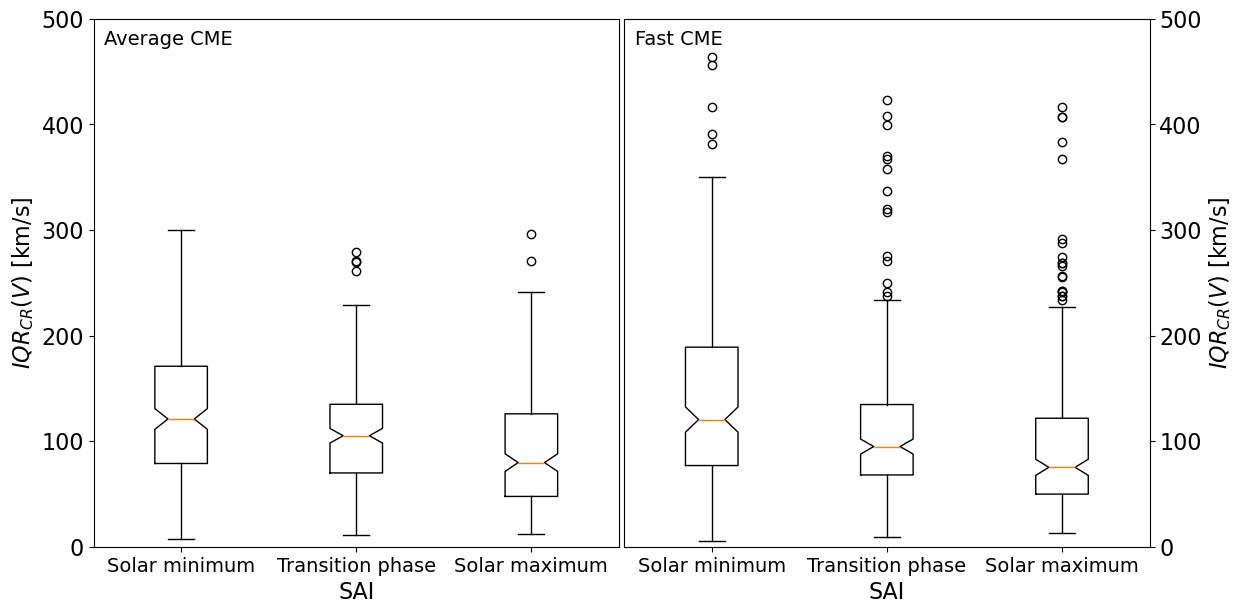

In [59]:
def boxplot_sai_arrival_iqr():
    """
    Produce a boxplot of the distributions of the arrival speed IQR in each Carrington rotation partitioned by the terciles of the SAI distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_v_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
        labels = ['Solar minimum', 'Transition phase', 'Solar maximum']
        print('Median for lower tercile',np.median(boxplot_data[0]))
        print('Median for middle tercile',np.median(boxplot_data[1]))
        print('Median for upper tercile',np.median(boxplot_data[2]))
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.set_xticklabels(labels, fontsize=14)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('SAI')
        a.set_ylabel(r'$IQR_{CR}(V)$ [km/s]')
        a.set_ylim(0,500)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/speed_boxplot.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')
    
    return

boxplot_sai_arrival_iqr()

/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


Average CME $\tilde{V}_{CR}$ - Solar minimum Median: 401.70
Average CME $\tilde{V}_{CR}$ - Solar maximum Median: 376.57
Average CME $IQR_{CR}(V)$ - Solar minimum Median: 120.98
Average CME $IQR_{CR}(V)$ - Solar maximum Median: 79.67
Fast CME $\tilde{V}_{CR}$ - Solar minimum Median: 455.52
Fast CME $\tilde{V}_{CR}$ - Solar maximum Median: 426.04
Fast CME $IQR_{CR}(V)$ - Solar minimum Median: 120.40
Fast CME $IQR_{CR}(V)$ - Solar maximum Median: 75.20


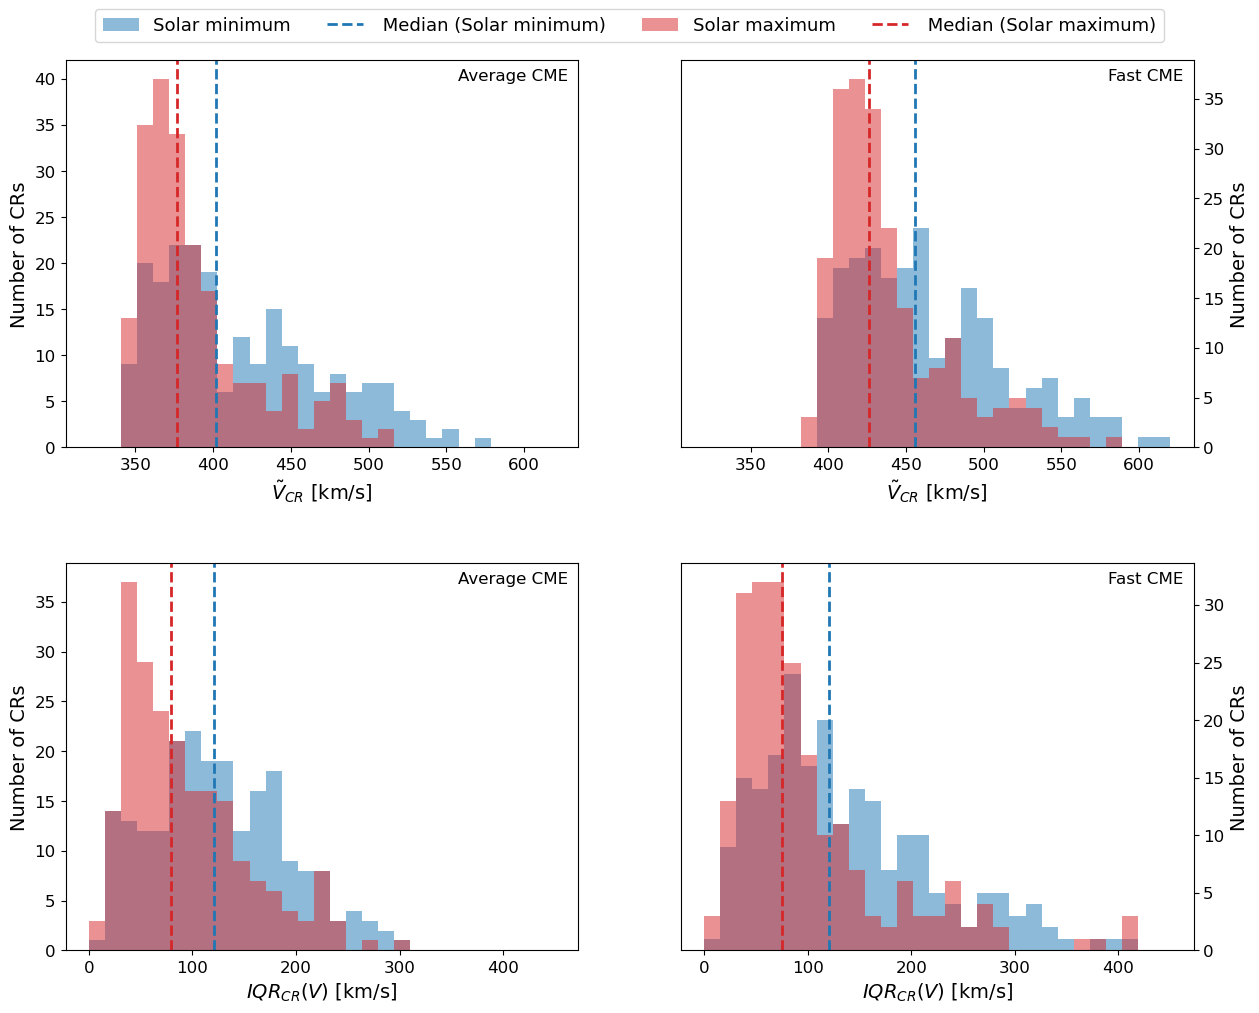

In [65]:
def histogram_sai_arrival_iqr_range():
    """
    Produce histograms of the 'iqr' and 'range' variables for the lower and upper terciles of the SAI distribution
    for both Average CME and Fast CME scenarios. The titles are moved inside the plot and a single combined legend is used for the entire figure.
    Returns:
    """
    cme_avg, cme_fst = load_reduced_v_data()
    
    datasets = [(cme_avg, 'Average CME'), (cme_fst, 'Fast CME')]
    colors = {'lower': 'tab:blue', 'upper': 'tab:red'}
    labels = {'lower': 'Solar minimum', 'upper': 'Solar maximum'}
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10), facecolor='white')
    handles, labels_legend = [], []
    
    for i, (cme, cme_label) in enumerate(datasets):
        terciles = cme['sai'].quantile([0.333, 0.666]).values
        id_low = cme['sai'] <= terciles[0]
        id_high = cme['sai'] > terciles[1]
        
        data_dict = {
            'lower': {'avg': cme.loc[id_low, 'avg'], 'iqr': cme.loc[id_low, 'iqr']},
            'upper': {'avg': cme.loc[id_high, 'avg'], 'iqr': cme.loc[id_high, 'iqr']}
        }
        
        for j, (var, title) in enumerate(zip(['avg', 'iqr'], [r'$\tilde{V}_{CR}$', r'$IQR_{CR}(V)$'])):
            bins = np.linspace(0 if var == 'iqr' else 320, 450 if var == 'iqr' else 620, 30)
            
            for key in ['lower', 'upper']:
                hist = ax[j, i].hist(data_dict[key][var], bins=bins, density=False, alpha=0.5, color=colors[key])
                median_value = np.median(data_dict[key][var])
                ax[j, i].axvline(median_value, color=colors[key], linestyle='dashed', linewidth=2)
                
                print(f'{cme_label} {title} - {labels[key]} Median: {median_value:.2f}')
                
                if i == 0 and j == 0:  # Collect legend handles once
                    handles.append(hist[2][0])
                    labels_legend.append(f'{labels[key]}')
                    handles.append(plt.Line2D([0], [0], color=colors[key], linestyle='dashed', linewidth=2))
                    labels_legend.append(f' Median ({labels[key]})')
            
            ax[j, i].set_xlabel(f'{title} [km/s]', fontsize=14)
            ax[j, i].set_ylabel('Number of CRs', fontsize=14)
            ax[j, i].tick_params(axis='y', labelsize=12)
            ax[j, i].tick_params(axis='x', labelsize=12)
            
            #ax[j, i].set_ylim(0, 0.1)
            ax[j, i].text(0.98, 0.98, f'{cme_label}', transform=ax[j, i].transAxes, fontsize=12, ha='right', va='top')
    
    # Move y-axis of second column to the right
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position('right')
    ax[1, 1].yaxis.tick_right()
    ax[1, 1].yaxis.set_label_position('right')
    
    fig.legend(handles, labels_legend, loc='upper center', ncol=4, bbox_to_anchor=(0.52, 1.05), fontsize=13)
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2, hspace=0.3)
    
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/speed_histogram.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches='tight')
    
    return

histogram_sai_arrival_iqr_range()


/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_29165/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']


Average CME:Median: (D=0.281, p=5.895e-08)
Average CME:IQR: (D=0.286, p=3.296e-08)
Fast CME:Median: (D=0.323, p=2.191e-10)
Fast CME:IQR: (D=0.272, p=1.830e-07)


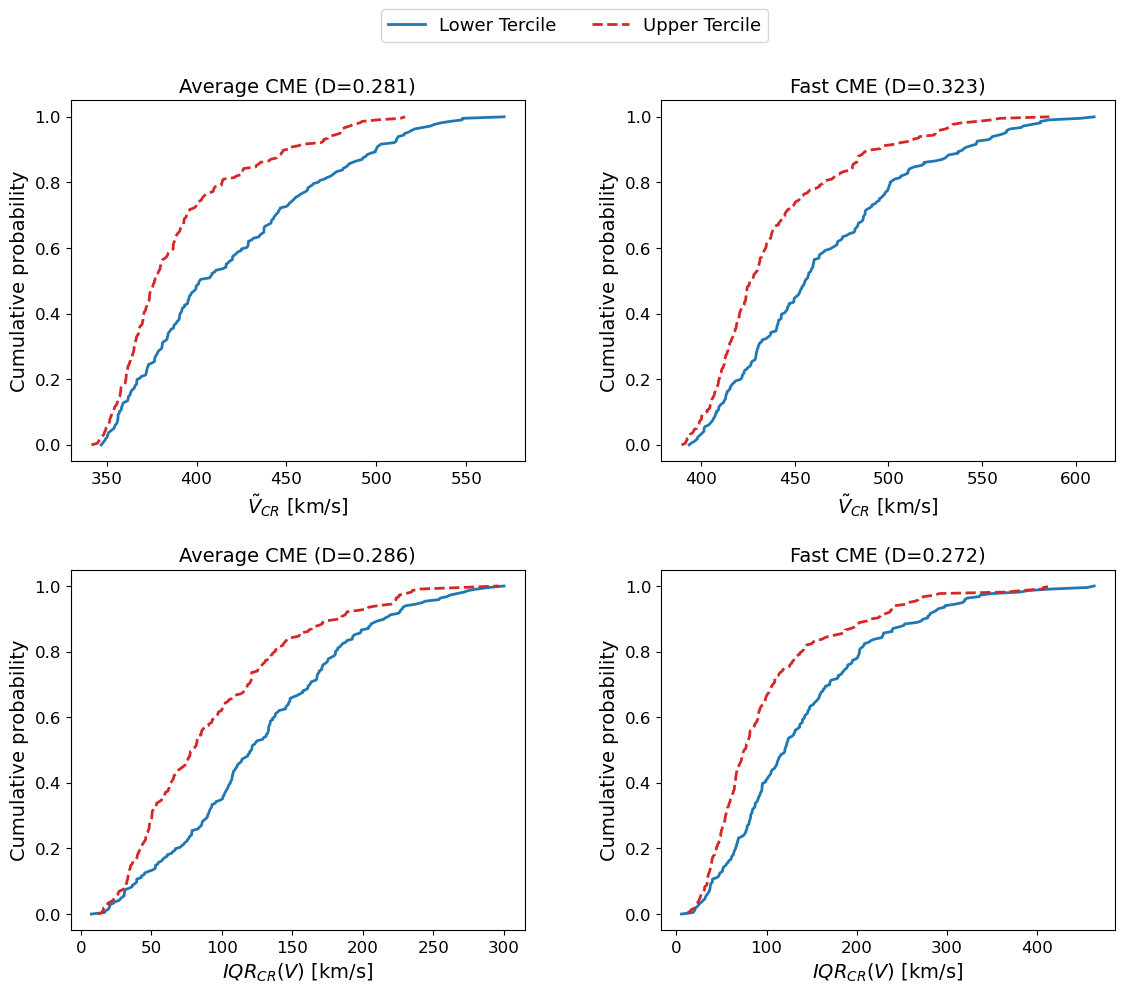

In [68]:
def ks_test_sai_arrival_with_cdf():
    """
    Perform the KS test and visualize empirical CDFs for arrival speed IQR and Range
    between the lower and upper terciles of SAI for both Average and Fast CME scenarios.
    """

    cme_avg, cme_fst = load_reduced_v_data()

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)

    for i, (cme, label) in enumerate(zip([cme_avg, cme_fst], ["Average CME", "Fast CME"])):
        # Calculate terciles
        terciles = cme['sai'].quantile([0.333, 0.666]).values

        # Identify lower and upper terciles
        id_low = cme['sai'] <= terciles[0]
        id_high = cme['sai'] > terciles[1]

        # Data for lower and upper terciles
        low_avg = np.sort(cme.loc[id_low, 'avg'])
        high_avg = np.sort(cme.loc[id_high, 'avg'])
        low_iqr = np.sort(cme.loc[id_low, 'iqr'])
        high_iqr = np.sort(cme.loc[id_high, 'iqr'])

        # Compute empirical CDFs
        cdf_low_avg = np.linspace(0, 1, len(low_avg))
        cdf_high_avg = np.linspace(0, 1, len(high_avg))
        cdf_low_iqr = np.linspace(0, 1, len(low_iqr))
        cdf_high_iqr = np.linspace(0, 1, len(high_iqr))

        # Perform KS test
        ks_stat_avg, p_value_avg = st.ks_2samp(low_avg, high_avg)
        ks_stat_iqr, p_value_iqr = st.ks_2samp(low_iqr, high_iqr)
        print((f"{label}:Median: (D={ks_stat_avg:.3f}, p={p_value_avg:.3e})"))
        print((f"{label}:IQR: (D={ks_stat_iqr:.3f}, p={p_value_iqr:.3e})"))

        # Plot CDF for Range
        axes[0, i].plot(low_avg, cdf_low_avg, label="Lower Tercile", color="tab:blue", linewidth=2)
        axes[0, i].plot(high_avg, cdf_high_avg, label="Upper Tercile", color="tab:red", linestyle="dashed", linewidth=2)
        axes[0, i].set_title(f"{label} (D={ks_stat_avg:.3f})", fontsize=14, loc="center")
        axes[0, i].set_xlabel(r'$\tilde{V}_{CR}$ [km/s]', fontsize=14)
        axes[0, i].set_ylabel("Cumulative probability", fontsize=14)
        axes[0, i].tick_params(axis='y', labelsize=12)
        axes[0, i].tick_params(axis='x', labelsize=12)
        
        # Plot CDF for IQR
        axes[1, i].plot(low_iqr, cdf_low_iqr, label="Lower Tercile", color="tab:blue", linewidth=2)
        axes[1, i].plot(high_iqr, cdf_high_iqr, label="Upper Tercile", color="tab:red", linestyle="dashed", linewidth=2)
        axes[1, i].set_title(f"{label} (D={ks_stat_iqr:.3f})", fontsize=14, loc="center")
        axes[1, i].set_xlabel(r'$IQR_{CR}(V)$ [km/s]', fontsize=14)
        axes[1, i].set_ylabel("Cumulative probability", fontsize=14)
        axes[1, i].tick_params(axis='y', labelsize=12)
        axes[1, i].tick_params(axis='x', labelsize=12)

    # Single legend for all subplots
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), fontsize=13, ncol=2)

    # Adjust layout for better spacing
    fig.subplots_adjust(left=0.08, bottom=0.12, right=0.95, top=0.95, wspace=0.3, hspace=0.3)

    # Save the figure
    fig_name = "/Users/dven/repos/CME_transit_climatology_new/figures/speed_ks_cdf.pdf"
    fig.savefig(fig_name, dpi=300, bbox_inches="tight")

    plt.show()

# Run the function
ks_test_sai_arrival_with_cdf()


In [33]:
from scipy.stats import mannwhitneyu

def perform_mann_whitney():
    """
    Perform Mann-Whitney U test between lower and upper terciles for:
    - Fast CME IQR
    - Fast CME Range
    - Average CME IQR
    - Average CME Range
    """
    cme_avg, cme_fst = load_reduced_v_data()

    comparisons = [
        ('Fast CME IQR', cme_fst['iqr']),
        ('Fast CME Range', cme_fst['range']),
        ('Average CME IQR', cme_avg['iqr']),
        ('Average CME Range', cme_avg['range'])
    ]
    
    for label, data in comparisons:
        terciles = data.quantile([0.333, 0.666]).values
        lower_tercile = data[data <= terciles[0]]
        upper_tercile = data[data > terciles[1]]

        stat, p_value = mannwhitneyu(lower_tercile, upper_tercile, alternative='two-sided')
        print(f"{label}: Mann-Whitney U test statistic = {stat:.3f}, p-value = {p_value:.3g}")

perform_mann_whitney()


/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/miniconda3/envs/huxt/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Fast CME IQR: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72
Fast CME Range: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72
Average CME IQR: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72
Average CME Range: Mann-Whitney U test statistic = 0.000, p-value = 1.35e-72


/var/folders/ny/0p_7l18s37704rxbjw3bptmw0000gn/T/ipykernel_39780/431099776.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ssn_df['smooth']
